In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile as SP
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
import math
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import bisect

**1. X,y Dataframes Creation, Train Test Dataframes Creation**
    *Import the data*
**2. X, y Summary Stats
**3. Data Exploration


## 1) X,y Dataframes Creation, Train Test Dataframes Creation

In [3]:
df = pd.read_csv('train.csv', index_col = 'id')

X_test = pd.read_csv('test.csv', index_col='id')

# Dropping the rows which have missing prediction values
df = df.dropna(axis=0, subset=['price_doc'])

X_train = df.copy()

X_train=X_train[(X_train.price_doc>1e6) & (X_train.price_doc!=2e6) & (X_train.price_doc!=3e6)]
X_train.loc[(X_train.product_type=='Investment') & (X_train.build_year<2000),'price_doc']*=0.9 
X_train.loc[X_train.product_type!='Investment','price_doc']*=0.969 #Louis/Andy's magic number

y_train = X_train.price_doc
X_train.drop(columns=['price_doc'], inplace=True)

In [4]:
print(X_train.shape)
print(X_test.shape)

(28402, 290)
(7662, 290)


## 2) X, y Summary Stats

### X Summary Stats

In [5]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

In [6]:
X_train.dtypes.value_counts()

int64      155
float64    119
object      16
dtype: int64

In [7]:
info = pd.DataFrame(X_train.dtypes, columns=['Dtypes'])
info['Unique'] = X_train.nunique().values
info['Null'] = X_train.isnull().sum().values
info

,Dtypes,Unique,Null
timestamp,object,1158,0
full_sq,int64,210,0
life_sq,float64,175,6380
floor,float64,41,151
max_floor,float64,49,8856
...,...,...,...
church_count_5000,int64,249,0
mosque_count_5000,int64,3,0
leisure_count_5000,int64,107,0
sport_count_5000,int64,216,0


In [8]:
'''correlation_matrix = df.corr()

# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', 
            square=True, mask=mask, linewidths=1, cbar=False)
plt.show()'''

"correlation_matrix = df.corr()\n\n# Returns copy of array with upper part of the triangle (which will be masked/hidden)\nmask = np.triu(correlation_matrix.corr())\n\nsns.set(font_scale=1.1)\nplt.figure(figsize=(20, 20), dpi=140)\nsns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', \n            square=True, mask=mask, linewidths=1, cbar=False)\nplt.show()"

### Y Summary Stats

In [9]:
y_train.describe()

count    2.840200e+04
mean     7.165558e+06
std      4.550945e+06
min      9.135000e+05
25%      4.875382e+06
50%      6.120000e+06
75%      8.010000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

/apps/python/v3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


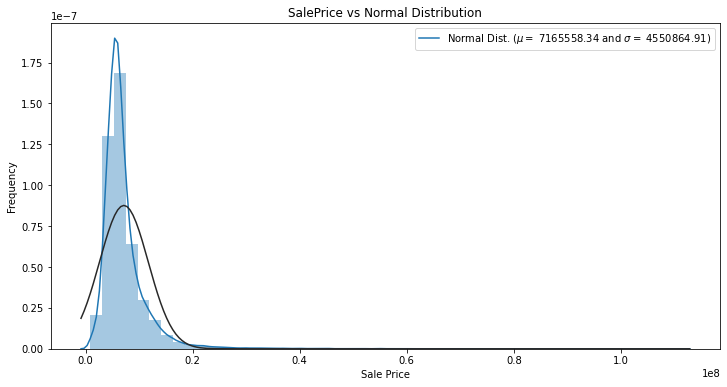

In [10]:
(mu, sigma) = stats.norm.fit(y_train)
plt.figure(figsize = (12,6))
sns.distplot(y_train, kde=True, hist=True, fit=stats.norm)
plt.title("SalePrice vs Normal Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.show()

Since the response variable SalePrice is not normal we will apply a log transform to make it normal

The final evaluation metric for the kaggle competition is also based on the RMSE between predicted and actual values therefore we would apply an exponential transform to the predicted values before submitting

mu = 7.93 and sigma = 0.10



/apps/python/v3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


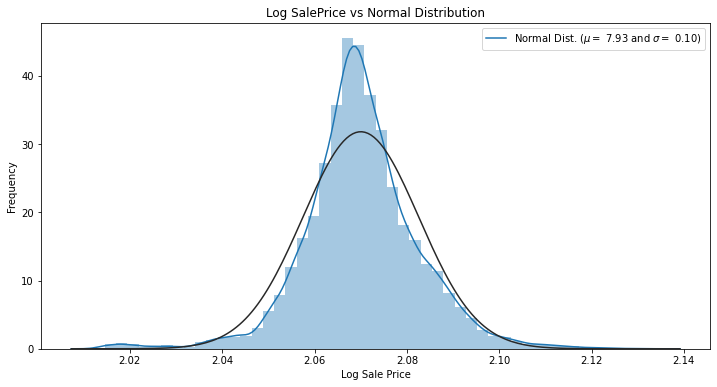

In [11]:
y_train_box_cox, y_train_lambda = stats.boxcox(y_train)
(mu, sigma) = stats.norm.fit(y_train_box_cox)
print('mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.figure(figsize = (12,6))
sns.distplot(np.log(y_train_box_cox), kde=True, hist=True, fit=stats.norm)
plt.title("Log SalePrice vs Normal Distribution")
plt.xlabel("Log Sale Price")
plt.ylabel("Frequency")
plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.show()

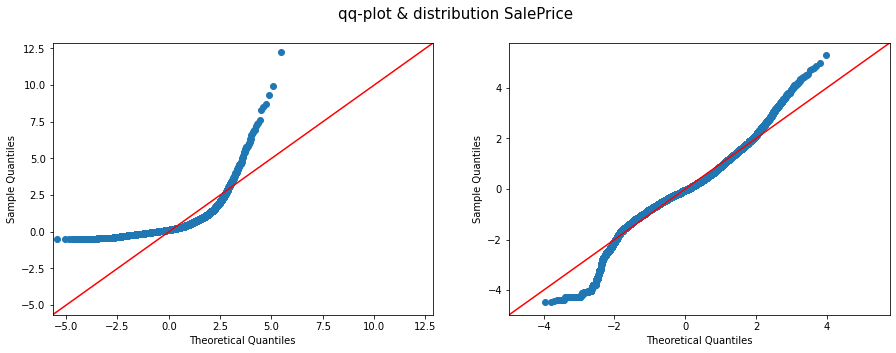

In [12]:
# SalePrice before and after transformation
fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)
sm.qqplot(y_train, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sm.qqplot(y_train_box_cox, fit=True, line = "45", ax=ax[1])
plt.show()

## 3) Data Exploration

In [14]:
X_train.head(1)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

#### Creating time columns and dropping the timestamp column

In [15]:
print("Total Missing Values")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Total Missing Values
Training data	 252881
Testing data	 47138


In [16]:
def null_values(X_train, X_test):
    null_train = X_train.isnull().sum()
    null_test = X_test.isnull().sum()
    
    df_dict = {'Train Data': null_train,
                'Test Data': null_test}
    null_df = pd.DataFrame(df_dict)
    
    null_df = null_df.loc[(null_df['Train Data']!=0) | (null_df['Test Data']!=0)]
    null_df = null_df.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    return null_df

In [17]:
null_vals = null_values(X_train, X_test)
null_vals

,Train Data,Test Data
hospital_beds_raion,13681,3418
build_year,12880,1049
state,12722,694
cafe_sum_500_min_price_avg,12700,3159
cafe_sum_500_max_price_avg,12700,3159
cafe_avg_price_500,12700,3159
max_floor,8856,0
material,8856,0
num_room,8856,0
kitch_sq,8856,0


In [18]:
print("Total Missing Values")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Total Missing Values
Training data	 252881
Testing data	 47138


### Data Visualisation for Categorical Data

In [19]:
cat_cols = X_train.select_dtypes('object').columns

In [20]:
'''fig, ax = plt.subplots(nrows=ceil(len(cat_cols) / 4), ncols=4, figsize=(22, 1.4*len(cat_cols)), sharey=True, dpi=120)

for col, subplot in zip(cat_cols, ax.flatten()):
    freq = X_train[col].value_counts()
    subplot.ticklabel_format(style='plain')
    plt.ylim([0, 800000])
    plt.subplots_adjust(wspace=.1,hspace=.4)
    for tick in subplot.get_xticklabels():
        tick.set_rotation(45)
    sns.violinplot(data=X_train, x=col, y=df.price_doc, order=freq.index, ax=subplot)'''

"fig, ax = plt.subplots(nrows=ceil(len(cat_cols) / 4), ncols=4, figsize=(22, 1.4*len(cat_cols)), sharey=True, dpi=120)\n\nfor col, subplot in zip(cat_cols, ax.flatten()):\n    freq = X_train[col].value_counts()\n    subplot.ticklabel_format(style='plain')\n    plt.ylim([0, 800000])\n    plt.subplots_adjust(wspace=.1,hspace=.4)\n    for tick in subplot.get_xticklabels():\n        tick.set_rotation(45)\n    sns.violinplot(data=X_train, x=col, y=df.price_doc, order=freq.index, ax=subplot)"

## 4) Feature Engineering

In [21]:
df = pd.concat([X_train, X_test])

### Filling in Values for Null rows

In [22]:
def get_build_index(sub_area, period):
    return ck[c.index(sub_area)][period]

def get_sum(row):
    row_sum = (row['build_count_before_1920']+
        row['build_count_1921-1945'] + 
        row['build_count_1946-1970']+
        row['build_count_1971-1995']+
        row['build_count_after_1995']
    )
    return row_sum

def get_year_built(row):
    periods = [row['build_count_before_1920'],row['build_count_1921-1945'],row['build_count_1946-1970'],row['build_count_1971-1995'],row['build_count_after_1995']]
    max_val = max(periods)
    max_ind = periods.index(max_val)
    if(max_val!=0):
        return mean_build_year[max_ind]

In [23]:
# ID Railroad Station Walk
df['ID_railroad_station_walk'] = df.groupby(['sub_area'], sort=False)['ID_railroad_station_walk'].apply(lambda x: x.fillna(x.mode()[0])) 

# Green Zone KM
df['green_zone_km'] = df['green_zone_km'].apply(lambda x : 0.0001 if x==0 else x)

# Metro Min Walk
df['metro_min_walk'] = df.groupby(['sub_area'], sort=False)['metro_min_walk'].apply(lambda x: x.fillna(x.mean())) 

#Metro KM Walk
df['metro_km_walk'] = df.groupby(['sub_area'], sort=False)['metro_km_walk'].apply(lambda x: x.fillna(x.mean()))

# Railroad Station Walk
df['railroad_station_walk_km'] = df.groupby(['sub_area'], sort=False)['railroad_station_walk_km'].apply(lambda x: x.fillna(x.mean()))

# Hospital Beds Raion
df['hospital_beds_raion'] = df['hospital_beds_raion'].fillna(value=0) # fill hospital bed

# Railroad Station Walk Min
df['railroad_station_walk_min'] = df.groupby(['sub_area'], sort=False)['railroad_station_walk_min'].apply(lambda x: x.fillna(x.mean()))

# verified that these neighbourhoods have no schools/preschools so we fill null
df['school_quota'] = df['school_quota'].fillna(value=0)
df['preschool_quota'] = df['preschool_quota'].fillna(value=0)

# State
df['state'] = df.apply(
    lambda row: np.NaN if (row['state']==33) else row['state'],
    axis=1
)
df['state'] = df.groupby(['sub_area'], sort=False)['state'].apply(lambda x: x.fillna(np.floor(x.median())))
df.loc[(df['state'].isnull()) & (df['sub_area']=='Poselenie Klenovskoe'),'state'] = 2

# Max Floor
df['max_floor'] = df['max_floor'].apply(lambda x: 90 if x>90 else x)
df['max_floor'] = df.groupby(['sub_area'], sort=False)['max_floor'].apply(lambda x: x.fillna(np.floor(x.median())))
df['max_floor'] = df['max_floor'].apply(lambda x: 1 if x==0 else x)

# Floor
df['floor'] = df.apply(lambda x: x.max_floor if x.floor > x.max_floor else x.floor, axis=1)
df['floor'] = df.apply(lambda x: 1 if x.floor==0.0 else x.floor, axis=1)
df['floor'] = df.groupby(['sub_area'], sort=False)['floor'].apply(lambda x: x.fillna(np.floor(x.median())))

# Full Sq
df['full_sq'] = df.apply(lambda x: 15 if x.full_sq < 15 else x.full_sq, axis=1)

# Life Sq
df['life_sq'] = df.apply(lambda x: 10 if x.life_sq < 10 else x.life_sq, axis=1)
df['life_sq'] = df.apply(lambda x: x.full_sq if x.life_sq > x.full_sq else x.life_sq, axis=1)
df['life_sq'] = df.groupby(['sub_area'], sort=False)['life_sq'].apply(lambda x: x.fillna(np.floor(x.median())))

# Kitch Sq
df['kitch_sq'] = df.apply(lambda x: (x.life_sq - 20) if ((x.kitch_sq > x.life_sq) & (x.life_sq > 25)) else x.kitch_sq, axis=1)
df['kitch_sq'] = df.apply(lambda x: 5 if ((x.kitch_sq > x.life_sq) & (x.life_sq <= 25)) else x.kitch_sq, axis=1)
df['kitch_sq'] = df.groupby(['sub_area'], sort=False)['life_sq'].apply(lambda x: x.fillna(np.floor(x.mean())))

# Num Room
df['num_room'] = df.apply(lambda x: 1 if x.num_room==0 else x.num_room, axis=1)
df['num_room'] = df.groupby(['sub_area'], sort=False)['num_room'].apply(lambda x: x.fillna(np.floor(x.median())))

# Material
df['material'] = df.groupby(['sub_area'], sort=False)['material'].apply(lambda x: x.fillna(x.mode()[0])) 

# Build Count
df['build_count_block'] = df['build_count_block'].fillna((np.ceil(df['build_count_block'].mean())))                                  
df['build_count_wood'] = df['build_count_wood'].fillna(value = np.ceil(df['build_count_wood'].mean()))
df['build_count_frame'] = df['build_count_frame'].fillna(value = np.ceil(df['build_count_frame'].mean()))
df['build_count_brick'] = df['build_count_brick'].fillna(value = np.ceil(df['build_count_brick'].mean()))
df['build_count_monolith'] = df['build_count_monolith'].fillna(value = np.ceil(df['build_count_monolith'].mean()))
df['build_count_panel'] = df['build_count_panel'].fillna(value = np.ceil(df['build_count_panel'].mean()))
df['build_count_foam'] = df['build_count_foam'].fillna(value = np.ceil(df['build_count_foam'].mean()))
df['build_count_slag'] = df['build_count_slag'].fillna(value = np.ceil(df['build_count_slag'].mean()))
df['build_count_mix'] = df['build_count_mix'].fillna(value = np.ceil(df['build_count_mix'].mean()))

build_count_sum = (np.ceil(df['build_count_block'].mean())+
   np.ceil(df['build_count_wood'].mean())+
    np.ceil(df['build_count_frame'].mean())+       
    np.ceil(df['build_count_brick'].mean())+
    np.ceil(df['build_count_monolith'].mean())+
    np.ceil(df['build_count_panel'].mean())+
    np.ceil(df['build_count_foam'].mean())+               
    np.ceil(df['build_count_slag'].mean())+
    np.ceil(df['build_count_mix'].mean())                
)

# Build Count Raion
df['raion_build_count_with_material_info'] = df['raion_build_count_with_material_info'].fillna(value=build_count_sum)

c = list(df[df['build_count_1921-1945'].isna()]['sub_area'].unique())

ck = np.ones(shape=(15,5))

for i in range(len(c)):
    build_years = list(df[df['sub_area'] == c[i]]['build_year'].dropna())
    for j in range(len(build_years)):
        if(build_years[j]<=1920):
            ck[i][0] += 1
        elif(1920<build_years[j]<=1945):
            ck[i][1] += 1
        elif(1945<build_years[j]<=1970):
            ck[i][2] += 1
        elif(1970<build_years[j]<=1995):
            ck[i][3] += 1
        else:
            ck[i][4] += 1
            
df['build_count_before_1920'] = df.apply(
    lambda row: get_build_index(row['sub_area'], 0) if np.isnan(row['build_count_before_1920']) else row['build_count_before_1920'],
    axis=1
)

df['build_count_1921-1945'] = df.apply(
    lambda row: get_build_index(row['sub_area'], 1) if np.isnan(row['build_count_1921-1945']) else row['build_count_1921-1945'],
    axis=1
)

df['build_count_1946-1970'] = df.apply(
    lambda row: get_build_index(row['sub_area'], 2) if np.isnan(row['build_count_1946-1970']) else row['build_count_1946-1970'],
    axis=1
)

df['build_count_1971-1995'] = df.apply(
    lambda row: get_build_index(row['sub_area'], 3) if np.isnan(row['build_count_1971-1995']) else row['build_count_1971-1995'],
    axis=1
)

df['build_count_after_1995'] = df.apply(
    lambda row: get_build_index(row['sub_area'], 4) if np.isnan(row['build_count_after_1995']) else row['build_count_after_1995'],
    axis=1
)

df['raion_build_count_with_builddate_info'] = df.apply(
    lambda row: get_sum(row) if np.isnan(row['raion_build_count_with_builddate_info']) else row['raion_build_count_with_builddate_info'],
    axis=1
)

df['build_year'] = df.apply(
    lambda row: np.NaN if ((row['build_year']<1471) | (row['build_year']>2020)) else row['build_year'],
    axis=1
) # set na for bad indexes

mean_build_year = np.ceil(
[
   df[df['build_year']<=1920]['build_year'].mean(),
   df[(df['build_year']>1920) & (df['build_year']<=1945)]['build_year'].mean(),
   df[(df['build_year']>1945) & (df['build_year']<=1970)]['build_year'].mean(),
   df[(df['build_year']>1970) & (df['build_year']<=1995)]['build_year'].mean(),
   df[df['build_year']>1995]['build_year'].mean()
    
]) # get mean build year for each period

df['build_year'] = df.apply(
    lambda row: get_year_built(row) if np.isnan(row['build_year']) else row['build_year'],
    axis=1
)

df['prom_part_5000'] = df.groupby(['sub_area'], sort=False)['prom_part_5000'].apply(lambda x: x.fillna(x.mode()[0]))

cafe_ranges = ['500', '1000', '1500', '2000', '3000', '5000' ]

for cafe_range in cafe_ranges:
    df['cafe_sum_{0}_min_price_avg'.format(cafe_range)] = df.groupby(['sub_area'], sort=False)['cafe_sum_{0}_min_price_avg'.format(cafe_range)].apply(lambda x: x.fillna(x.mean())) 
    df['cafe_sum_{0}_max_price_avg'.format(cafe_range)] = df.groupby(['sub_area'], sort=False)['cafe_sum_{0}_max_price_avg'.format(cafe_range)].apply(lambda x: x.fillna(x.mean())) 
    df['cafe_avg_price_{0}'.format(cafe_range)] = df.groupby(['sub_area'], sort=False)['cafe_avg_price_{0}'.format(cafe_range)].apply(lambda x: x.fillna(x.mean()))
    
    df['cafe_sum_{0}_min_price_avg'.format(cafe_range)] = df['cafe_sum_{0}_min_price_avg'.format(cafe_range)].fillna(value=df['cafe_sum_{0}_min_price_avg'.format(cafe_range)].mean())
    df['cafe_sum_{0}_max_price_avg'.format(cafe_range)] = df['cafe_sum_{0}_max_price_avg'.format(cafe_range)].fillna(value=df['cafe_sum_{0}_max_price_avg'.format(cafe_range)].mean())
    df['cafe_avg_price_{0}'.format(cafe_range)] = df['cafe_avg_price_{0}'.format(cafe_range)].fillna(value=df['cafe_avg_price_{0}'.format(cafe_range)].mean())
    
df['product_type'] = df.groupby(['sub_area'], sort=False)['product_type'].apply(lambda x: x.fillna(x.mode()[0]))
df['green_part_2000'] = df.groupby(['sub_area'], sort=False)['green_part_2000'].apply(lambda x: x.fillna(x.mode()[0]))

In [24]:
columns_to_drop = ['cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000','cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000','cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000','cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000','cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000','cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'cafe_count_500_price_500', 'cafe_count_500_price_500','cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'mosque_count_5000', 'mosque_count_3000', 'mosque_count_2000', 'mosque_count_1500', 'mosque_count_1000', 'mosque_count_500']
df.drop(columns=columns_to_drop, inplace=True)

In [25]:
print("Total Missing Values: ", df.isnull().sum().sum()) 

Total Missing Values:  0


In [26]:
null_dict = {}
for col in df.columns:
    if( df[col].isnull().sum()>0):
        null_dict[col] = df[col].isnull().sum()
        
{k: v for k, v in sorted(null_dict.items(), key=lambda item: item[1])}

{}

### Feature Engineering

In [27]:
df['day'] = df.timestamp.apply(lambda x: int(x[8:10]))
df['month'] = df.timestamp.apply(lambda x: int(x[5:7]))
df['year'] = df.timestamp.apply(lambda x: int(x[0:4]))
df.drop(columns=['timestamp'], inplace=True)

In [28]:
# Shivangi
df['each_room_size'] = df['life_sq'] / df['num_room'].astype(float)
df['years_old'] = df['year'] - df['build_year'].astype(float)
df['years_old'] = df['years_old'].apply(lambda x:0 if x<0 else x)
df['young_percent'] = (df['young_all'] / df['full_all']).astype(float)*100
df['working_percent'] = (df['work_all'] / df['full_all']).astype(float)*100
df['elder_percent'] = (df['ekder_all'] / df['full_all']).astype(float)*100
df['nature_percent'] = (df['green_zone_part'] / df['full_all']).astype(float)*100
df['education_num'] = df['school_education_centers_raion'] + df['preschool_education_centers_raion'] +df['sport_objects_raion'].astype(float)

In [29]:
# Sneha Copy
df['dimension_sub_area'] = df['area_m'].apply(np.sqrt,0)
df['extra_sq'] = df['full_sq'] - df['life_sq'].astype(float) 
df['liveArea_ratio'] = df['life_sq']/df['full_sq'].astype(float)
df['living_area_per_floor'] = df['life_sq']/df['max_floor'].astype(float)
df['gender_ratio'] = df['male_f']/df['female_f'].astype(float)
df['kindergarden_park_ratio'] = df['kindergarten_km']/df['park_km'].astype(float)
df['school_seat_avail'] = df['school_quota']/df['children_school'].astype(float)
df['preschool_seat_avail'] = df['preschool_quota']/df['children_school'].astype(float)
df['school_closeness'] = df['school_km']/df['dimension_sub_area'].astype(float)
df['preschool_closeness'] = df['preschool_km']/df['dimension_sub_area'].astype(float)
df['are_school_same'] = df['preschool_km'] == df['school_km'].astype(float)
df['office_closeness'] = df['office_km']/df['dimension_sub_area'].astype(float)
df['work_avail'] = df['office_raion']/df['work_all'].astype(float)
df['healthcare_density'] = 1e7 * df['healthcare_centers_raion']/df['area_m'].astype(float)
df['pollution_coeff_nature_ratio'] = df['industrial_km']/df['green_zone_km'].astype(float)
df['pollution_coeff_water_ratio'] = df['industrial_km']/df['water_treatment_km'].astype(float)
df['publichealth_closeness'] = df['public_healthcare_km']/df['dimension_sub_area'].astype(float)
df['shop_density'] = 1e7 * df['shopping_centers_raion'] / df['area_m'].astype(float)
df['shops_closeness'] = df['shopping_centers_km']/df['dimension_sub_area'].astype(float)
df['preschool_per_area'] = 1e7 * df['preschool_education_centers_raion']/df['area_m'].astype(float)
df['school_per_area'] = 1e7 * df['school_education_centers_raion']/df['area_m'].astype(float)
df['build_cound_before_1995'] = df['build_count_before_1920'] + df['build_count_1921-1945'] + df['build_count_1946-1970'] + df['build_count_1971-1995'].astype(float)
df['new_or_old_city'] = df['build_cound_before_1995']/df['build_cound_before_1995'].astype(float)

In [30]:
# Nihal edits

df['sport_count_5000'] = df['sport_count_5000'] - df['sport_count_3000']
df['sport_count_3000'] = df['sport_count_3000'] - df['sport_count_2000']
df['sport_count_2000'] = df['sport_count_2000'] - df['sport_count_1500']
df['sport_count_1500'] = df['sport_count_1500'] - df['sport_count_1000']
df['sport_count_1000'] = df['sport_count_1000'] - df['sport_count_500']

df['leisure_count_5000'] = df['leisure_count_5000'] - df['leisure_count_3000']
df['leisure_count_3000'] = df['leisure_count_3000'] - df['leisure_count_2000']
df['leisure_count_2000'] = df['leisure_count_2000'] - df['leisure_count_1500']
df['leisure_count_1500'] = df['leisure_count_1500'] - df['leisure_count_1000']
df['leisure_count_1000'] = df['leisure_count_1000'] - df['leisure_count_500']

df['activities_count_5000'] = 1.75*df['leisure_count_5000'] + df['sport_count_5000'] 
df['activities_count_3000'] = 1.75*df['leisure_count_3000'] + df['sport_count_3000']
df['activities_count_2000'] = 1.75*df['leisure_count_2000'] + df['sport_count_2000']
df['activities_count_1500'] = 1.75*df['leisure_count_1500'] + df['sport_count_1500']
df['activities_count_1000'] = 1.75*df['leisure_count_1000'] + df['sport_count_1000']
df['activities_count_500'] = 1.75*df['leisure_count_500'] + df['sport_count_500']

df['office_count_5000'] = df['office_count_5000'] - df['office_count_3000']
df['office_count_3000'] = df['office_count_3000'] - df['office_count_2000']
df['office_count_2000'] = df['office_count_2000'] - df['office_count_1500']
df['office_count_1500'] = df['office_count_1500'] - df['office_count_1000']
df['office_count_1000'] = df['office_count_1000'] - df['office_count_500']

df['office_sqm_5000'] = df['office_sqm_5000'] - df['office_sqm_3000']
df['office_sqm_3000'] = df['office_sqm_3000'] - df['office_sqm_2000']
df['office_sqm_2000'] = df['office_sqm_2000'] - df['office_sqm_1500']
df['office_sqm_1500'] = df['office_sqm_1500'] - df['office_sqm_1000']
df['office_sqm_1000'] = df['office_sqm_1000'] - df['office_sqm_500']

df['cafe_count_5000'] = df['cafe_count_5000'] - df['cafe_count_3000']
df['cafe_count_3000'] = df['cafe_count_3000'] - df['cafe_count_2000']
df['cafe_count_2000'] = df['cafe_count_2000'] - df['cafe_count_1500']
df['cafe_count_1500'] = df['cafe_count_1500'] - df['cafe_count_1000']
df['cafe_count_1000'] = df['cafe_count_1000'] - df['cafe_count_500']

df['green_part_5000'] = df['green_part_5000'] - df['green_part_3000']
df['green_part_3000'] = df['green_part_3000'] - df['green_part_2000']
df['green_part_2000'] = df['green_part_2000'] - df['green_part_1500']
df['green_part_1500'] = df['green_part_1500'] - df['green_part_1000']
df['green_part_1000'] = df['green_part_1000'] - df['green_part_500']

df['prom_part_5000'] = df['prom_part_5000'] - df['prom_part_3000']
df['prom_part_3000'] = df['prom_part_3000'] - df['prom_part_2000']
df['prom_part_2000'] = df['prom_part_2000'] - df['prom_part_1500']
df['prom_part_1500'] = df['prom_part_1500'] - df['prom_part_1000']
df['prom_part_1000'] = df['prom_part_1000'] - df['prom_part_500']

df['market_count_5000'] = df['market_count_5000'] - df['market_count_3000']
df['market_count_3000'] = df['market_count_3000'] - df['market_count_2000']
df['market_count_2000'] = df['market_count_2000'] - df['market_count_1500']
df['market_count_1500'] = df['market_count_1500'] - df['market_count_1000']
df['market_count_1000'] = df['market_count_1000'] - df['market_count_500']

df['trc_count_5000'] = df['trc_count_5000'] - df['trc_count_3000']
df['trc_count_3000'] = df['trc_count_3000'] - df['trc_count_2000']
df['trc_count_2000'] = df['trc_count_2000'] - df['trc_count_1500']
df['trc_count_1500'] = df['trc_count_1500'] - df['trc_count_1000']
df['trc_count_1000'] = df['trc_count_1000'] - df['trc_count_500']

df['trc_sqm_5000'] = df['trc_sqm_5000'] - df['trc_sqm_3000']
df['trc_sqm_3000'] = df['trc_sqm_3000'] - df['trc_sqm_2000']
df['trc_sqm_2000'] = df['trc_sqm_2000'] - df['trc_sqm_1500']
df['trc_sqm_1500'] = df['trc_sqm_1500'] - df['trc_sqm_1000']
df['trc_sqm_1000'] = df['trc_sqm_1000'] - df['trc_sqm_500']

df['church_count_5000'] = df['church_count_5000'] - df['church_count_3000']
df['church_count_3000'] = df['church_count_3000'] - df['church_count_2000']
df['church_count_2000'] = df['church_count_2000'] - df['church_count_1500']
df['church_count_1500'] = df['church_count_1500'] - df['church_count_1000']
df['church_count_1000'] = df['church_count_1000'] - df['church_count_500']

df['small_church_count_5000'] = df['church_count_5000']-df['big_church_count_5000']
df['total_church_count_5000'] = 1.1*df['big_church_count_5000']+0.9*df['small_church_count_5000']

df['small_church_count_3000'] = df['church_count_3000']-df['big_church_count_3000']
df['total_church_count_3000'] = 1.1*df['big_church_count_3000']+0.9*df['small_church_count_3000']

df['small_church_count_2000'] = df['church_count_2000']-df['big_church_count_2000']
df['total_church_count_2000'] = 1.1*df['big_church_count_2000']+0.9*df['small_church_count_2000']

df['small_church_count_1500'] = df['church_count_1500']-df['big_church_count_1500']
df['total_church_count_1500'] = 1.1*df['big_church_count_1500']+0.9*df['small_church_count_1500']

df['small_church_count_1000'] = df['church_count_1000']-df['big_church_count_1000']
df['total_church_count_1000'] = 1.1*df['big_church_count_1000']+0.9*df['small_church_count_1000']

df['small_church_count_500'] = df['church_count_500']-df['big_church_count_500']
df['total_church_count_500'] = 1.1*df['big_church_count_500']+0.9*df['small_church_count_500']


In [31]:
df['activities_count_5000'] = 1.75*df['leisure_count_5000'] + df['sport_count_5000'] 
df['activities_count_3000'] = 1.75*df['leisure_count_3000'] + df['sport_count_3000']
df['activities_count_2000'] = 1.75*df['leisure_count_2000'] + df['sport_count_2000']
df['activities_count_1500'] = 1.75*df['leisure_count_1500'] + df['sport_count_1500']
df['activities_count_1000'] = 1.75*df['leisure_count_1000'] + df['sport_count_1000']
df['activities_count_500'] = 1.75*df['leisure_count_500'] + df['sport_count_500']

In [32]:
drop_columns = ['small_church_count_5000', 'church_count_5000', 'big_church_count_5000', 'small_church_count_3000', 'church_count_3000', 'big_church_count_3000', 'small_church_count_2000', 'church_count_2000', 'big_church_count_2000', 'small_church_count_1500', 'church_count_1500', 'big_church_count_1500', 'small_church_count_1000', 'church_count_1000', 'big_church_count_1000', 'small_church_count_500', 'church_count_500', 'big_church_count_500', 'leisure_count_5000', 'sport_count_5000', 'leisure_count_3000', 'sport_count_3000', 'leisure_count_2000', 'sport_count_2000', 'leisure_count_1500', 'sport_count_1500', 'leisure_count_1000', 'sport_count_1000', 'leisure_count_500', 'sport_count_500']

In [33]:
df.drop(columns=drop_columns, inplace=True)

In [34]:
df.sample()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_1000,cafe_count_500_price_1500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_1500,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_1500,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_1500,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_1500,market_count_5000,day,month,year,each_room_size,years_old,young_percent,working_percent,elder_percent,nature_percent,education_num,dimension_sub_area,extra_sq,liveArea_ratio,living_area_per_floor,gender_ratio,kindergarden_park_ratio,school_seat_avail,preschool_seat_avail,school_closeness,preschool_closeness,are_school_same,office_closeness,work_avail,healthcare_density,pollution_coeff_nature_ratio,pollution_

In [35]:
df.shape

(36064, 263)

In [36]:
df.isna().sum().sum()

0

In [37]:
null_dict = {}
for col in df.columns:
    if( df[col].isnull().sum()>0):
        null_dict[col] = df[col].isnull().sum()
        
{k: v for k, v in sorted(null_dict.items(), key=lambda item: item[1])}

{}

### Label Encoding Categorical Columns for MI Score and VIF 

In [38]:
def MultiColumnLabelEncoderFitTransform(data, categorical_features):
    columns = {}
    for col in categorical_features:
        le = LabelEncoder()
        columns[col] = {'encoder': le.fit(data[col])}
        data[col] = columns[col]['encoder'].transform(data[col])
    return data, columns

In [39]:
def MultiColumnLabelEncoderInverseTransform(data, categorical_features, le_fits):
    for col in categorical_features:
        if col in data.columns.tolist():
            le = le_fits[col]['encoder']
            print(le_fits[col]['encoder'])
            data[col] = le.inverse_transform(data[col])
    return data

In [40]:
categorical_features = list(df.select_dtypes('object').columns)

In [41]:
df, le_fits = MultiColumnLabelEncoderFitTransform(df, categorical_features)

In [42]:
le_fits

{'product_type': {'encoder': LabelEncoder()},
 'sub_area': {'encoder': LabelEncoder()},
 'culture_objects_top_25': {'encoder': LabelEncoder()},
 'thermal_power_plant_raion': {'encoder': LabelEncoder()},
 'incineration_raion': {'encoder': LabelEncoder()},
 'oil_chemistry_raion': {'encoder': LabelEncoder()},
 'radiation_raion': {'encoder': LabelEncoder()},
 'railroad_terminal_raion': {'encoder': LabelEncoder()},
 'big_market_raion': {'encoder': LabelEncoder()},
 'nuclear_reactor_raion': {'encoder': LabelEncoder()},
 'detention_facility_raion': {'encoder': LabelEncoder()},
 'water_1line': {'encoder': LabelEncoder()},
 'big_road1_1line': {'encoder': LabelEncoder()},
 'railroad_1line': {'encoder': LabelEncoder()},
 'ecology': {'encoder': LabelEncoder()}}

In [43]:
X_train = df.loc[X_train.index, :]
X_test = df.loc[X_test.index, :]

In [44]:
print(X_train.shape)
print(X_test.shape)

(28402, 263)
(7662, 263)


## 5) Feature Selection

In [45]:
X_train.isna().sum().sum()

0

In [46]:
y_train.isna().sum()

0

In [47]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [48]:
null_dict = {}
for col in X_train.columns:
    if( X_train[col].isnull().sum()>0):
        null_dict[col] = X_train[col].isnull().sum()
        
{k: v for k, v in sorted(null_dict.items(), key=lambda item: item[1])}

{}

In [49]:
def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    # discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X.select_dtypes('number'), y, random_state=0)
    mi_scores = pd.DataFrame(mi_scores.round(2), columns=["MI_Scores"], index=X.select_dtypes('number').columns)
    return mi_scores

In [50]:
def feature_selector(num_features, X):
    data = X.copy()
    selected_features = []

    for row in corr_with_price.head(num_features).index:
        selected_features.append(''+row)
    X_model = pd.DataFrame(data).loc[:,selected_features]
    
    return X_model

In [51]:
mi_scores = make_mi_scores(X_train, y_train)
linear_corr = pd.DataFrame(X_train.corrwith(y_train).round(2), columns=['Lin_Correlation'])

corr_with_price = pd.concat([mi_scores, linear_corr], axis=1)
corr_with_price = corr_with_price.sort_values('MI_Scores',ascending=False)

corr_with_price

,MI_Scores,Lin_Correlation
full_sq,0.74,0.35
sub_area,0.58,-0.11
extra_sq,0.57,0.20
0_13_female,0.57,0.17
0_13_male,0.57,0.17
...,...,...
big_road1_1line,0.00,0.07
new_or_old_city,0.00,NaN
oil_chemistry_raion,0.00,-0.02
day,0.00,0.01


In [52]:
top = sum(corr_with_price.MI_Scores>0.0)

In [53]:
X_train_mi_features = feature_selector(top, X_train)

In [54]:
X_train_mi_features

,full_sq,sub_area,extra_sq,0_13_female,0_13_male,0_13_all,0_17_male,0_17_all,7_14_female,7_14_all,0_6_male,work_female,work_male,young_female,young_male,young_all,0_17_female,raion_popul,children_school,ekder_female,children_preschool,work_all,ekder_all,ekder_male,0_6_all,0_6_female,build_cound_before_1995,7_14_male,16_29_all,green_zone_part,16_29_female,female_f,male_f,full_all,16_29_male,gender_ratio,each_room_size,dimension_sub_area,area_m,nature_percent,raion_build_count_with_builddate_info,liveArea_ratio,build_count_after_1995,indust_part,kitch_sq,life_sq,build_count_1971-1995,young_percent,working_percent,elder_percent,ID_railroad_station_avto,build_count_1946-1970,ID_railroad_station_walk,ID_metro,raion_build_count_with_material_info,bulvar_ring_km,kremlin_km,build_count_panel,ttk_km,sadovoe_km,zd_vokzaly_avto_km,oil_chemistry_km,cafe_avg_price_5000,basketball_km,school_seat_avail,detention_facility_km,education_num,years_old,nuclear_reactor_km,preschool_per_area,school_per_area,preschool_seat_avail,university_km,metro_km_walk,metro_min_walk,metro_km_avto,thermal_power_plant_km,build_count_block,kindergarten_km,big_church_km,stadium_km,radiation_km,school_quota,swim_pool_km,exhibition_km,power_transmission_line_km,catering_km,workplaces_km,preschool_km,incineration_km,metro_min_avto,preschool_quota,school_km,product_type,cafe_count_5000_price_1500,cafe_avg_price_3000,fitness_km,office_km,shopping_centers_km,build_count_brick,public_healthcare_km,total_church_count_5000,ID_big_road2,theater_km,cafe_avg_price_1500,ts_km,school_closeness,mkad_km,hospice_morgue_km,park_km,mosque_km,museum_km,build_year,trc_sqm_5000,cafe_count_5000,living_area_per_floor,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,public_transport_station_min_walk,publichealth_closeness,shops_closeness,additional_education_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,public_transport_station_km,office_closeness,cafe_count_3000_price_1500,activities_count_5000,big_road2_km,bus_terminal_avto_km,cafe_avg_price_1000,big_market_km,railroad_km,green_part_3000,prom_part_5000,office_sqm_5000,trc_count_5000,green_part_1500,build_count_monolith,green_part_2000,big_road1_km,cemetery_km,green_part_5000,sport_objects_raion,cafe_count_2000_price_1500,prom_part_3000,industrial_km,cafe_count_5000_na_price,ID_bus_terminal,kindergarden_park_ratio,church_synagogue_km,green_part_1000,pollution_coeff_water_ratio,school_education_centers_raion,water_km,trc_sqm_3000,cafe_avg_price_500,shop_density,cafe_count_3000,preschool_education_centers_raion,trc_count_3000,green_zone_km,total_church_count_3000,prom_part_1500,build_count_before_1920,state,office_count_5000,build_count_wood,prom_part_2000,max_floor,cafe_count_1500,activities_count_3000,cafe_count_2000,cafe_count_1500_price_1500,prom_part_1000,ecology,cafe_count_3000_na_price,work_avail,pollution_coeff_nature_ratio,green_part_500,cafe_count_1000,num_room,build_count_slag,activities_count_1500,activities_count_2000,shopping_centers_raion,build_count_frame,hospital_beds_raion,build_count_1921-1945,office_count_3000,total_church_count_2000,market_count_5000,cafe_count_1000_price_1500,office_sqm_3000,healthcare_density,prom_part_500,office_raion,cafe_count_2000_na_price,activities_count_1000,additional_education_raion,year,trc_sqm_2000,trc_count_2000,ID_railroad_terminal,total_church_count_1500,build_count_mix,healthcare_centers_raion,trc_sqm_1500,office_count_2000,cafe_count_500,trc_count_1500,cafe_count_1500_na_price,office_sqm_2000,office_count_1500,build_count_foam,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,activities_count_500,trc_count_1000,office_count_1000,cafe_count_1000_na_price,office_sqm_1000,cafe_count_500_price_1000,cafe_count_500_price_1500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,office_sqm_500,floor,trc_count_500,month,market_count_20

In [55]:
vif_dropped_columns = []
vif_value = []

In [56]:
VIF = X_train_mi_features.copy()

for i in tqdm(range(200)):
    X = VIF[list(X_train_mi_features.columns)].copy()
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in tqdm(range(X.shape[1]))]
    vif_info['Column'] = X.columns
    vif_info.sort_values(by='VIF', ascending=False, inplace=True)
    vif_info.reset_index(inplace=True)
    vif_info.drop(columns=['index'], inplace=True)
    vif = vif_info['VIF'][0]
    print(vif)
    inf_columns = []
    for i in range(len(vif_info)):
        if math.isinf(vif_info['VIF'][i]):
            inf_columns.append(vif_info['Column'][i])
    min_mi_score = 100
    drop_var = ''
    for i in inf_columns:
        if mi_scores['MI_Scores'][i]<min_mi_score:
            min_mi_score = mi_scores['MI_Scores'][i]
            drop_var = i
    vif_dropped_columns.append(drop_var)
    vif_value.append(vif)
    if vif>156861961334380.17:
        X_train_mi_features.drop(columns=[drop_var], inplace=True)
    else:
        break

  0%|          | 0/258 [00:00<?, ?it/s]/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)

  0%|          | 0/257 [00:00<?, ?it/s]

inf



  0%|          | 0/256 [00:00<?, ?it/s]

inf



  0%|          | 0/255 [00:00<?, ?it/s]

inf



  0%|          | 0/254 [00:00<?, ?it/s]

inf



  0%|          | 0/253 [00:00<?, ?it/s]

inf



  0%|          | 0/252 [00:00<?, ?it/s]

inf



  0%|          | 0/251 [00:00<?, ?it/s]

inf



  0%|          | 0/250 [00:00<?, ?it/s]

inf



  0%|          | 0/249 [00:00<?, ?it/s]

inf



  0%|          | 0/248 [00:00<?, ?it/s]

inf



  0%|          | 0/247 [00:00<?, ?it/s]

inf



  0%|          | 0/246 [00:00<?, ?it/s]

inf



  6%|▌         | 12/200 [32:38<8:31:16, 163.17s/it]

126861961334380.17


In [57]:
dropped_columns = pd.DataFrame({'Column Name': vif_dropped_columns,
                                'VIF': vif_value})
dropped_columns

,Column Name,VIF
0,build_count_foam,inf
1,build_count_1921-1945,inf
2,preschool_education_centers_raion,inf
3,public_transport_station_min_walk,inf
4,railroad_station_walk_km,inf
5,metro_min_walk,inf
6,life_sq,inf
7,build_count_after_1995,inf
8,kitch_sq,inf
9,work_all,inf


In [58]:
vif_info

,VIF,Column
0,1.268620e+14,full_all
1,5.737070e+13,raion_popul
2,3.737427e+13,female_f
3,2.656991e+13,male_f
4,8.736372e+12,16_29_all
...,...,...
241,2.842256e+00,living_area_per_floor
242,2.429229e+00,pollution_coeff_nature_ratio
243,2.205132e+00,kindergarden_park_ratio
244,2.127043e+00,water_1line


In [59]:
X_train_mi_features

,full_sq,sub_area,extra_sq,0_13_female,0_13_male,0_13_all,0_17_male,0_17_all,7_14_female,7_14_all,0_6_male,work_female,work_male,young_female,young_male,young_all,0_17_female,raion_popul,ekder_female,children_preschool,ekder_all,ekder_male,0_6_female,build_cound_before_1995,7_14_male,16_29_all,green_zone_part,16_29_female,female_f,male_f,full_all,16_29_male,gender_ratio,each_room_size,dimension_sub_area,area_m,nature_percent,raion_build_count_with_builddate_info,liveArea_ratio,indust_part,build_count_1971-1995,young_percent,working_percent,elder_percent,ID_railroad_station_avto,build_count_1946-1970,ID_railroad_station_walk,ID_metro,raion_build_count_with_material_info,bulvar_ring_km,kremlin_km,build_count_panel,ttk_km,sadovoe_km,zd_vokzaly_avto_km,oil_chemistry_km,cafe_avg_price_5000,basketball_km,school_seat_avail,detention_facility_km,education_num,years_old,nuclear_reactor_km,preschool_per_area,school_per_area,preschool_seat_avail,university_km,metro_km_walk,metro_km_avto,thermal_power_plant_km,build_count_block,kindergarten_km,big_church_km,stadium_km,radiation_km,school_quota,swim_pool_km,exhibition_km,power_transmission_line_km,catering_km,workplaces_km,preschool_km,incineration_km,metro_min_avto,preschool_quota,school_km,product_type,cafe_count_5000_price_1500,cafe_avg_price_3000,fitness_km,office_km,shopping_centers_km,build_count_brick,public_healthcare_km,total_church_count_5000,ID_big_road2,theater_km,cafe_avg_price_1500,ts_km,school_closeness,mkad_km,hospice_morgue_km,park_km,mosque_km,museum_km,build_year,trc_sqm_5000,cafe_count_5000,living_area_per_floor,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,publichealth_closeness,shops_closeness,additional_education_km,railroad_station_walk_min,railroad_station_avto_km,public_transport_station_km,office_closeness,cafe_count_3000_price_1500,activities_count_5000,big_road2_km,bus_terminal_avto_km,cafe_avg_price_1000,big_market_km,railroad_km,green_part_3000,prom_part_5000,office_sqm_5000,trc_count_5000,green_part_1500,build_count_monolith,green_part_2000,big_road1_km,cemetery_km,green_part_5000,sport_objects_raion,cafe_count_2000_price_1500,prom_part_3000,industrial_km,cafe_count_5000_na_price,ID_bus_terminal,kindergarden_park_ratio,church_synagogue_km,green_part_1000,pollution_coeff_water_ratio,school_education_centers_raion,water_km,trc_sqm_3000,cafe_avg_price_500,shop_density,cafe_count_3000,trc_count_3000,green_zone_km,total_church_count_3000,prom_part_1500,build_count_before_1920,state,office_count_5000,build_count_wood,prom_part_2000,max_floor,cafe_count_1500,activities_count_3000,cafe_count_2000,cafe_count_1500_price_1500,prom_part_1000,ecology,cafe_count_3000_na_price,work_avail,pollution_coeff_nature_ratio,green_part_500,cafe_count_1000,num_room,build_count_slag,activities_count_1500,activities_count_2000,shopping_centers_raion,build_count_frame,hospital_beds_raion,office_count_3000,total_church_count_2000,market_count_5000,cafe_count_1000_price_1500,office_sqm_3000,healthcare_density,prom_part_500,office_raion,cafe_count_2000_na_price,activities_count_1000,additional_education_raion,year,trc_sqm_2000,trc_count_2000,ID_railroad_terminal,total_church_count_1500,build_count_mix,healthcare_centers_raion,trc_sqm_1500,office_count_2000,cafe_count_500,trc_count_1500,cafe_count_1500_na_price,office_sqm_2000,office_count_1500,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,activities_count_500,trc_count_1000,office_count_1000,cafe_count_1000_na_price,office_sqm_1000,cafe_count_500_price_1000,cafe_count_500_price_1500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,office_sqm_500,floor,trc_count_500,month,market_count_2000,cafe_count_500_na_price,trc_sqm_500,market_count_1000,big_market_raion,market_count_1500,university_top_20_raion,culture_objects_top_25_raion,water_1line,thermal_power_plant_raion,market_count_500,school_education_cen

In [60]:
vif_info.set_index('Column', inplace = True)

In [61]:
columns_to_use = X_train_mi_features.columns.tolist()

In [62]:
columns_to_use

['full_sq',
 'sub_area',
 'extra_sq',
 '0_13_female',
 '0_13_male',
 '0_13_all',
 '0_17_male',
 '0_17_all',
 '7_14_female',
 '7_14_all',
 '0_6_male',
 'work_female',
 'work_male',
 'young_female',
 'young_male',
 'young_all',
 '0_17_female',
 'raion_popul',
 'ekder_female',
 'children_preschool',
 'ekder_all',
 'ekder_male',
 '0_6_female',
 'build_cound_before_1995',
 '7_14_male',
 '16_29_all',
 'green_zone_part',
 '16_29_female',
 'female_f',
 'male_f',
 'full_all',
 '16_29_male',
 'gender_ratio',
 'each_room_size',
 'dimension_sub_area',
 'area_m',
 'nature_percent',
 'raion_build_count_with_builddate_info',
 'liveArea_ratio',
 'indust_part',
 'build_count_1971-1995',
 'young_percent',
 'working_percent',
 'elder_percent',
 'ID_railroad_station_avto',
 'build_count_1946-1970',
 'ID_railroad_station_walk',
 'ID_metro',
 'raion_build_count_with_material_info',
 'bulvar_ring_km',
 'kremlin_km',
 'build_count_panel',
 'ttk_km',
 'sadovoe_km',
 'zd_vokzaly_avto_km',
 'oil_chemistry_km',
 

In [63]:
X_train_vif = X_train[X_train_mi_features.columns.tolist()]

In [64]:
X_train_vif

,full_sq,sub_area,extra_sq,0_13_female,0_13_male,0_13_all,0_17_male,0_17_all,7_14_female,7_14_all,0_6_male,work_female,work_male,young_female,young_male,young_all,0_17_female,raion_popul,ekder_female,children_preschool,ekder_all,ekder_male,0_6_female,build_cound_before_1995,7_14_male,16_29_all,green_zone_part,16_29_female,female_f,male_f,full_all,16_29_male,gender_ratio,each_room_size,dimension_sub_area,area_m,nature_percent,raion_build_count_with_builddate_info,liveArea_ratio,indust_part,build_count_1971-1995,young_percent,working_percent,elder_percent,ID_railroad_station_avto,build_count_1946-1970,ID_railroad_station_walk,ID_metro,raion_build_count_with_material_info,bulvar_ring_km,kremlin_km,build_count_panel,ttk_km,sadovoe_km,zd_vokzaly_avto_km,oil_chemistry_km,cafe_avg_price_5000,basketball_km,school_seat_avail,detention_facility_km,education_num,years_old,nuclear_reactor_km,preschool_per_area,school_per_area,preschool_seat_avail,university_km,metro_km_walk,metro_km_avto,thermal_power_plant_km,build_count_block,kindergarten_km,big_church_km,stadium_km,radiation_km,school_quota,swim_pool_km,exhibition_km,power_transmission_line_km,catering_km,workplaces_km,preschool_km,incineration_km,metro_min_avto,preschool_quota,school_km,product_type,cafe_count_5000_price_1500,cafe_avg_price_3000,fitness_km,office_km,shopping_centers_km,build_count_brick,public_healthcare_km,total_church_count_5000,ID_big_road2,theater_km,cafe_avg_price_1500,ts_km,school_closeness,mkad_km,hospice_morgue_km,park_km,mosque_km,museum_km,build_year,trc_sqm_5000,cafe_count_5000,living_area_per_floor,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,publichealth_closeness,shops_closeness,additional_education_km,railroad_station_walk_min,railroad_station_avto_km,public_transport_station_km,office_closeness,cafe_count_3000_price_1500,activities_count_5000,big_road2_km,bus_terminal_avto_km,cafe_avg_price_1000,big_market_km,railroad_km,green_part_3000,prom_part_5000,office_sqm_5000,trc_count_5000,green_part_1500,build_count_monolith,green_part_2000,big_road1_km,cemetery_km,green_part_5000,sport_objects_raion,cafe_count_2000_price_1500,prom_part_3000,industrial_km,cafe_count_5000_na_price,ID_bus_terminal,kindergarden_park_ratio,church_synagogue_km,green_part_1000,pollution_coeff_water_ratio,school_education_centers_raion,water_km,trc_sqm_3000,cafe_avg_price_500,shop_density,cafe_count_3000,trc_count_3000,green_zone_km,total_church_count_3000,prom_part_1500,build_count_before_1920,state,office_count_5000,build_count_wood,prom_part_2000,max_floor,cafe_count_1500,activities_count_3000,cafe_count_2000,cafe_count_1500_price_1500,prom_part_1000,ecology,cafe_count_3000_na_price,work_avail,pollution_coeff_nature_ratio,green_part_500,cafe_count_1000,num_room,build_count_slag,activities_count_1500,activities_count_2000,shopping_centers_raion,build_count_frame,hospital_beds_raion,office_count_3000,total_church_count_2000,market_count_5000,cafe_count_1000_price_1500,office_sqm_3000,healthcare_density,prom_part_500,office_raion,cafe_count_2000_na_price,activities_count_1000,additional_education_raion,year,trc_sqm_2000,trc_count_2000,ID_railroad_terminal,total_church_count_1500,build_count_mix,healthcare_centers_raion,trc_sqm_1500,office_count_2000,cafe_count_500,trc_count_1500,cafe_count_1500_na_price,office_sqm_2000,office_count_1500,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,activities_count_500,trc_count_1000,office_count_1000,cafe_count_1000_na_price,office_sqm_1000,cafe_count_500_price_1000,cafe_count_500_price_1500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,office_sqm_500,floor,trc_count_500,month,market_count_2000,cafe_count_500_na_price,trc_sqm_500,market_count_1000,big_market_raion,market_count_1500,university_top_20_raion,culture_objects_top_25_raion,water_1line,thermal_power_plant_raion,market_count_500,school_education_cen

In [65]:
mi_scores = make_mi_scores(X_train_vif, y_train)
linear_corr = pd.DataFrame(X_train_vif.corrwith(y_train).round(2), columns=['Lin_Correlation'])

corr_with_price = pd.concat([mi_scores, linear_corr], axis=1)
corr_with_price = corr_with_price.sort_values('MI_Scores',ascending=False)

corr_with_price

,MI_Scores,Lin_Correlation
full_sq,0.74,0.35
sub_area,0.58,-0.11
work_female,0.57,0.17
7_14_male,0.57,0.17
ekder_all,0.57,0.21
...,...,...
thermal_power_plant_raion,0.01,0.04
market_count_500,0.01,0.05
railroad_terminal_raion,0.01,0.05
nuclear_reactor_raion,0.01,0.04


In [66]:
top = sum(corr_with_price.MI_Scores>0)

In [67]:
X_train_selected_features = feature_selector(top, X_train_vif)

In [68]:
X_train_selected_features

,full_sq,sub_area,work_female,7_14_male,ekder_all,ekder_female,raion_popul,0_17_female,young_all,young_female,work_male,young_male,0_6_male,0_17_male,0_13_female,0_13_all,0_13_male,0_17_all,7_14_female,children_preschool,7_14_all,ekder_male,0_6_female,build_cound_before_1995,extra_sq,male_f,dimension_sub_area,each_room_size,16_29_male,full_all,16_29_all,16_29_female,green_zone_part,female_f,liveArea_ratio,gender_ratio,area_m,nature_percent,raion_build_count_with_builddate_info,indust_part,young_percent,ID_railroad_station_avto,elder_percent,working_percent,build_count_1971-1995,ID_railroad_station_walk,ID_metro,build_count_1946-1970,raion_build_count_with_material_info,kremlin_km,build_count_panel,sadovoe_km,bulvar_ring_km,ttk_km,zd_vokzaly_avto_km,detention_facility_km,preschool_per_area,years_old,school_per_area,workplaces_km,nuclear_reactor_km,education_num,oil_chemistry_km,basketball_km,school_seat_avail,cafe_avg_price_5000,radiation_km,catering_km,power_transmission_line_km,exhibition_km,swim_pool_km,school_quota,stadium_km,big_church_km,kindergarten_km,build_count_block,thermal_power_plant_km,metro_km_avto,metro_km_walk,university_km,preschool_seat_avail,school_km,cafe_avg_price_3000,cafe_count_5000_price_1500,product_type,fitness_km,preschool_quota,incineration_km,metro_min_avto,preschool_km,ID_big_road2,build_year,theater_km,shopping_centers_km,build_count_brick,public_healthcare_km,office_km,total_church_count_5000,mosque_km,living_area_per_floor,cafe_count_5000,trc_sqm_5000,museum_km,hospice_morgue_km,park_km,school_closeness,ts_km,cafe_avg_price_1500,mkad_km,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,activities_count_5000,public_transport_station_km,big_road2_km,bus_terminal_avto_km,office_closeness,cafe_count_3000_price_1500,railroad_station_avto_km,additional_education_km,shops_closeness,publichealth_closeness,railroad_km,build_count_monolith,trc_count_5000,railroad_station_walk_min,big_market_km,cafe_avg_price_1000,green_part_3000,office_sqm_5000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,cafe_count_5000_na_price,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,sport_objects_raion,prom_part_3000,green_part_5000,cemetery_km,water_km,shop_density,trc_sqm_3000,cafe_avg_price_500,school_education_centers_raion,pollution_coeff_water_ratio,green_part_1000,cafe_count_2000_price_1500,prom_part_1500,state,build_count_before_1920,green_zone_km,cafe_count_3000,trc_count_3000,total_church_count_3000,office_count_5000,build_count_wood,prom_part_2000,activities_count_3000,cafe_count_2000,cafe_count_1500,max_floor,cafe_count_1500_price_1500,work_avail,cafe_count_3000_na_price,prom_part_1000,ecology,pollution_coeff_nature_ratio,cafe_count_1000,green_part_500,build_count_slag,num_room,activities_count_1500,build_count_frame,activities_count_2000,shopping_centers_raion,hospital_beds_raion,market_count_5000,office_count_3000,total_church_count_2000,prom_part_500,cafe_count_2000_na_price,cafe_count_1000_price_1500,healthcare_density,office_sqm_3000,activities_count_1000,office_raion,additional_education_raion,year,total_church_count_1500,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,cafe_count_500,trc_sqm_1500,office_count_2000,healthcare_centers_raion,build_count_mix,cafe_count_1500_na_price,office_count_1500,trc_count_1500,office_sqm_2000,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,office_sqm_1000,cafe_count_500_price_1500,cafe_count_500_price_1000,cafe_count_1000_na_price,office_count_1000,activities_count_500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,cafe_count_500_na_price,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,culture_objects_top_25_raion,school_education_centers_top_20_raion,railroad_1line,culture_ob

In [69]:
X_test_selected_features = X_test[X_train_selected_features.columns.tolist()]

In [70]:
X_test_selected_features

,full_sq,sub_area,work_female,7_14_male,ekder_all,ekder_female,raion_popul,0_17_female,young_all,young_female,work_male,young_male,0_6_male,0_17_male,0_13_female,0_13_all,0_13_male,0_17_all,7_14_female,children_preschool,7_14_all,ekder_male,0_6_female,build_cound_before_1995,extra_sq,male_f,dimension_sub_area,each_room_size,16_29_male,full_all,16_29_all,16_29_female,green_zone_part,female_f,liveArea_ratio,gender_ratio,area_m,nature_percent,raion_build_count_with_builddate_info,indust_part,young_percent,ID_railroad_station_avto,elder_percent,working_percent,build_count_1971-1995,ID_railroad_station_walk,ID_metro,build_count_1946-1970,raion_build_count_with_material_info,kremlin_km,build_count_panel,sadovoe_km,bulvar_ring_km,ttk_km,zd_vokzaly_avto_km,detention_facility_km,preschool_per_area,years_old,school_per_area,workplaces_km,nuclear_reactor_km,education_num,oil_chemistry_km,basketball_km,school_seat_avail,cafe_avg_price_5000,radiation_km,catering_km,power_transmission_line_km,exhibition_km,swim_pool_km,school_quota,stadium_km,big_church_km,kindergarten_km,build_count_block,thermal_power_plant_km,metro_km_avto,metro_km_walk,university_km,preschool_seat_avail,school_km,cafe_avg_price_3000,cafe_count_5000_price_1500,product_type,fitness_km,preschool_quota,incineration_km,metro_min_avto,preschool_km,ID_big_road2,build_year,theater_km,shopping_centers_km,build_count_brick,public_healthcare_km,office_km,total_church_count_5000,mosque_km,living_area_per_floor,cafe_count_5000,trc_sqm_5000,museum_km,hospice_morgue_km,park_km,school_closeness,ts_km,cafe_avg_price_1500,mkad_km,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,activities_count_5000,public_transport_station_km,big_road2_km,bus_terminal_avto_km,office_closeness,cafe_count_3000_price_1500,railroad_station_avto_km,additional_education_km,shops_closeness,publichealth_closeness,railroad_km,build_count_monolith,trc_count_5000,railroad_station_walk_min,big_market_km,cafe_avg_price_1000,green_part_3000,office_sqm_5000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,cafe_count_5000_na_price,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,sport_objects_raion,prom_part_3000,green_part_5000,cemetery_km,water_km,shop_density,trc_sqm_3000,cafe_avg_price_500,school_education_centers_raion,pollution_coeff_water_ratio,green_part_1000,cafe_count_2000_price_1500,prom_part_1500,state,build_count_before_1920,green_zone_km,cafe_count_3000,trc_count_3000,total_church_count_3000,office_count_5000,build_count_wood,prom_part_2000,activities_count_3000,cafe_count_2000,cafe_count_1500,max_floor,cafe_count_1500_price_1500,work_avail,cafe_count_3000_na_price,prom_part_1000,ecology,pollution_coeff_nature_ratio,cafe_count_1000,green_part_500,build_count_slag,num_room,activities_count_1500,build_count_frame,activities_count_2000,shopping_centers_raion,hospital_beds_raion,market_count_5000,office_count_3000,total_church_count_2000,prom_part_500,cafe_count_2000_na_price,cafe_count_1000_price_1500,healthcare_density,office_sqm_3000,activities_count_1000,office_raion,additional_education_raion,year,total_church_count_1500,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,cafe_count_500,trc_sqm_1500,office_count_2000,healthcare_centers_raion,build_count_mix,cafe_count_1500_na_price,office_count_1500,trc_count_1500,office_sqm_2000,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,office_sqm_1000,cafe_count_500_price_1500,cafe_count_500_price_1000,cafe_count_1000_na_price,office_count_1000,activities_count_500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,cafe_count_500_na_price,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,culture_objects_top_25_raion,school_education_centers_top_20_raion,railroad_1line,culture_ob

In [71]:
df_selected_features = pd.concat([X_train_selected_features, X_test_selected_features])

In [72]:
df_selected_features = df_selected_features.copy()

In [73]:
df_selected_features

,full_sq,sub_area,work_female,7_14_male,ekder_all,ekder_female,raion_popul,0_17_female,young_all,young_female,work_male,young_male,0_6_male,0_17_male,0_13_female,0_13_all,0_13_male,0_17_all,7_14_female,children_preschool,7_14_all,ekder_male,0_6_female,build_cound_before_1995,extra_sq,male_f,dimension_sub_area,each_room_size,16_29_male,full_all,16_29_all,16_29_female,green_zone_part,female_f,liveArea_ratio,gender_ratio,area_m,nature_percent,raion_build_count_with_builddate_info,indust_part,young_percent,ID_railroad_station_avto,elder_percent,working_percent,build_count_1971-1995,ID_railroad_station_walk,ID_metro,build_count_1946-1970,raion_build_count_with_material_info,kremlin_km,build_count_panel,sadovoe_km,bulvar_ring_km,ttk_km,zd_vokzaly_avto_km,detention_facility_km,preschool_per_area,years_old,school_per_area,workplaces_km,nuclear_reactor_km,education_num,oil_chemistry_km,basketball_km,school_seat_avail,cafe_avg_price_5000,radiation_km,catering_km,power_transmission_line_km,exhibition_km,swim_pool_km,school_quota,stadium_km,big_church_km,kindergarten_km,build_count_block,thermal_power_plant_km,metro_km_avto,metro_km_walk,university_km,preschool_seat_avail,school_km,cafe_avg_price_3000,cafe_count_5000_price_1500,product_type,fitness_km,preschool_quota,incineration_km,metro_min_avto,preschool_km,ID_big_road2,build_year,theater_km,shopping_centers_km,build_count_brick,public_healthcare_km,office_km,total_church_count_5000,mosque_km,living_area_per_floor,cafe_count_5000,trc_sqm_5000,museum_km,hospice_morgue_km,park_km,school_closeness,ts_km,cafe_avg_price_1500,mkad_km,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,activities_count_5000,public_transport_station_km,big_road2_km,bus_terminal_avto_km,office_closeness,cafe_count_3000_price_1500,railroad_station_avto_km,additional_education_km,shops_closeness,publichealth_closeness,railroad_km,build_count_monolith,trc_count_5000,railroad_station_walk_min,big_market_km,cafe_avg_price_1000,green_part_3000,office_sqm_5000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,cafe_count_5000_na_price,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,sport_objects_raion,prom_part_3000,green_part_5000,cemetery_km,water_km,shop_density,trc_sqm_3000,cafe_avg_price_500,school_education_centers_raion,pollution_coeff_water_ratio,green_part_1000,cafe_count_2000_price_1500,prom_part_1500,state,build_count_before_1920,green_zone_km,cafe_count_3000,trc_count_3000,total_church_count_3000,office_count_5000,build_count_wood,prom_part_2000,activities_count_3000,cafe_count_2000,cafe_count_1500,max_floor,cafe_count_1500_price_1500,work_avail,cafe_count_3000_na_price,prom_part_1000,ecology,pollution_coeff_nature_ratio,cafe_count_1000,green_part_500,build_count_slag,num_room,activities_count_1500,build_count_frame,activities_count_2000,shopping_centers_raion,hospital_beds_raion,market_count_5000,office_count_3000,total_church_count_2000,prom_part_500,cafe_count_2000_na_price,cafe_count_1000_price_1500,healthcare_density,office_sqm_3000,activities_count_1000,office_raion,additional_education_raion,year,total_church_count_1500,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,cafe_count_500,trc_sqm_1500,office_count_2000,healthcare_centers_raion,build_count_mix,cafe_count_1500_na_price,office_count_1500,trc_count_1500,office_sqm_2000,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,office_sqm_1000,cafe_count_500_price_1500,cafe_count_500_price_1000,cafe_count_1000_na_price,office_count_1000,activities_count_500,material,office_count_500,total_church_count_500,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,cafe_count_500_na_price,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,culture_objects_top_25_raion,school_education_centers_top_20_raion,railroad_1line,culture_ob

In [74]:
df_selected_features = MultiColumnLabelEncoderInverseTransform(df_selected_features, categorical_features, le_fits)

LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()


In [75]:
categorical_features = list(df_selected_features.select_dtypes('object').columns)

In [76]:
df_selected_features.dtypes.value_counts()

float64    140
int64       93
object      13
dtype: int64

In [77]:
correlation_matrix = df_selected_features.corr()

In [78]:
correlation_matrix.reset_index(inplace=True)

In [79]:
correlation_matrix

,index,full_sq,work_female,7_14_male,ekder_all,ekder_female,raion_popul,0_17_female,young_all,young_female,work_male,young_male,0_6_male,0_17_male,0_13_female,0_13_all,0_13_male,0_17_all,7_14_female,children_preschool,7_14_all,ekder_male,0_6_female,build_cound_before_1995,extra_sq,male_f,dimension_sub_area,each_room_size,16_29_male,full_all,16_29_all,16_29_female,green_zone_part,female_f,liveArea_ratio,gender_ratio,area_m,nature_percent,raion_build_count_with_builddate_info,indust_part,young_percent,ID_railroad_station_avto,elder_percent,working_percent,build_count_1971-1995,ID_railroad_station_walk,ID_metro,build_count_1946-1970,raion_build_count_with_material_info,kremlin_km,build_count_panel,sadovoe_km,bulvar_ring_km,ttk_km,zd_vokzaly_avto_km,detention_facility_km,preschool_per_area,years_old,school_per_area,workplaces_km,nuclear_reactor_km,education_num,oil_chemistry_km,basketball_km,school_seat_avail,cafe_avg_price_5000,radiation_km,catering_km,power_transmission_line_km,exhibition_km,swim_pool_km,school_quota,stadium_km,big_church_km,kindergarten_km,build_count_block,thermal_power_plant_km,metro_km_avto,metro_km_walk,university_km,preschool_seat_avail,school_km,cafe_avg_price_3000,cafe_count_5000_price_1500,fitness_km,preschool_quota,incineration_km,metro_min_avto,preschool_km,ID_big_road2,build_year,theater_km,shopping_centers_km,build_count_brick,public_healthcare_km,office_km,total_church_count_5000,mosque_km,living_area_per_floor,cafe_count_5000,trc_sqm_5000,museum_km,hospice_morgue_km,park_km,school_closeness,ts_km,cafe_avg_price_1500,mkad_km,market_shop_km,preschool_closeness,cafe_avg_price_2000,ice_rink_km,water_treatment_km,ID_big_road1,railroad_station_avto_min,activities_count_5000,public_transport_station_km,big_road2_km,bus_terminal_avto_km,office_closeness,cafe_count_3000_price_1500,railroad_station_avto_km,additional_education_km,shops_closeness,publichealth_closeness,railroad_km,build_count_monolith,trc_count_5000,railroad_station_walk_min,big_market_km,cafe_avg_price_1000,green_part_3000,office_sqm_5000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,cafe_count_5000_na_price,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,sport_objects_raion,prom_part_3000,green_part_5000,cemetery_km,water_km,shop_density,trc_sqm_3000,cafe_avg_price_500,school_education_centers_raion,pollution_coeff_water_ratio,green_part_1000,cafe_count_2000_price_1500,prom_part_1500,state,build_count_before_1920,green_zone_km,cafe_count_3000,trc_count_3000,total_church_count_3000,office_count_5000,build_count_wood,prom_part_2000,activities_count_3000,cafe_count_2000,cafe_count_1500,max_floor,cafe_count_1500_price_1500,work_avail,cafe_count_3000_na_price,prom_part_1000,pollution_coeff_nature_ratio,cafe_count_1000,green_part_500,build_count_slag,num_room,activities_count_1500,build_count_frame,activities_count_2000,shopping_centers_raion,hospital_beds_raion,market_count_5000,office_count_3000,total_church_count_2000,prom_part_500,cafe_count_2000_na_price,cafe_count_1000_price_1500,healthcare_density,office_sqm_3000,activities_count_1000,office_raion,additional_education_raion,year,total_church_count_1500,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,cafe_count_500,trc_sqm_1500,office_count_2000,healthcare_centers_raion,build_count_mix,cafe_count_1500_na_price,office_count_1500,trc_count_1500,office_sqm_2000,total_church_count_1000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,office_sqm_1000,cafe_count_500_price_1500,cafe_count_500_price_1000,cafe_count_1000_na_price,office_count_1000,activities_count_500,material,office_count_500,total_church_count_500,floor,trc_count_500,month,office_sqm_500,market_count_2000,cafe_count_500_na_price,trc_sqm_500,university_top_20_raion,market_count_1000,market_count_1500,culture_objects_top_25_raion,school_education_centers_top_20_raion,market_count_500
0,full_sq,1.000000,-0.030168,-0.015558,-0.036584,-0.038347,-0.030104,-0.017236,-0.017031,-0.0172

In [80]:
corr_with_price = corr_with_price.sort_values('Lin_Correlation',ascending=False)
corr_with_price.reset_index(inplace = True)

In [81]:
corr_with_price

,index,MI_Scores,Lin_Correlation
0,num_room,0.28,0.43
1,full_sq,0.74,0.35
2,trc_count_5000,0.40,0.32
3,activities_count_5000,0.41,0.32
4,office_sqm_5000,0.39,0.31
...,...,...,...
241,ttk_km,0.48,-0.31
242,bulvar_ring_km,0.48,-0.31
243,kremlin_km,0.49,-0.31
244,zd_vokzaly_avto_km,0.48,-0.32


In [82]:
result = corr_with_price.reindex(corr_with_price.Lin_Correlation.abs().sort_values(ascending=False).index)

In [83]:
result

,index,MI_Scores,Lin_Correlation
0,num_room,0.28,0.43
1,full_sq,0.74,0.35
244,zd_vokzaly_avto_km,0.48,-0.32
245,sadovoe_km,0.49,-0.32
2,trc_count_5000,0.40,0.32
...,...,...,...
150,prom_part_500,0.25,-0.01
146,each_room_size,0.55,0.01
147,total_church_count_500,0.09,0.01
149,green_part_1000,0.37,0.00


In [84]:
corr_with_price = result

In [85]:
# PCA for all rows individually

for i in tqdm(range(len(corr_with_price)-2)):
    checking_index = corr_with_price['index'][i]
    print('Constraint: ', len(correlation_matrix))
    for j in tqdm(range(len(correlation_matrix))):
        if j>=len(correlation_matrix):
            break
        new_df = pd.DataFrame()
        if checking_index in df_selected_features.columns.tolist():
            if checking_index not in categorical_features:
                if correlation_matrix[checking_index][j]!=1:
                    if correlation_matrix[checking_index][j]>0.8:
                        pca_column = correlation_matrix['index'][j]
                        print(pca_column)
                        new_df = df_selected_features[[checking_index, pca_column]].copy()
                        scaled_new_df = StandardScaler().fit_transform(new_df)

                        pca = PCA(n_components=1)
                        principalComponents = pca.fit_transform(scaled_new_df)

                        df_selected_features.drop(columns=[checking_index, pca_column], inplace=True)

                        df_selected_features[checking_index] = principalComponents
                        j = 0
                        correlation_matrix = df_selected_features.corr()
                        correlation_matrix.reset_index(inplace=True)
                        print('Length Currently :',len(correlation_matrix))
                        print(j)

100%|██████████| 233/233 [00:00<00:00, 5294.86it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

Constraint:  233
Constraint:  233
extra_sq



  0%|          | 0/232 [00:00<?, ?it/s]

Length Currently : 232
0
Constraint:  232
trc_sqm_5000



 42%|████▏     | 98/232 [00:03<00:04, 29.22it/s]

Length Currently : 231
0
activities_count_5000



 48%|████▊     | 112/232 [00:06<00:08, 14.61it/s]

Length Currently : 230
0
office_sqm_5000



 55%|█████▍    | 127/232 [00:09<00:10, 10.05it/s]

Length Currently : 229
0
cafe_count_5000_na_price



 56%|█████▋    | 131/232 [00:13<00:15,  6.57it/s]

Length Currently : 228
0
cafe_count_3000



 65%|██████▌   | 151/232 [00:16<00:12,  6.43it/s]

Length Currently : 227
0
total_church_count_3000



 66%|██████▌   | 152/232 [00:19<00:18,  4.39it/s]

Length Currently : 226
0
activities_count_3000



 67%|██████▋   | 155/232 [00:22<00:23,  3.28it/s]

Length Currently : 225
0
cafe_count_1500



 67%|██████▋   | 156/232 [00:25<00:32,  2.35it/s]

Length Currently : 224
0
cafe_count_1500_price_1500



 68%|██████▊   | 157/232 [00:29<00:43,  1.72it/s]

Length Currently : 223
0
cafe_count_3000_na_price



 68%|██████▊   | 158/232 [00:32<00:56,  1.30it/s]

Length Currently : 222
0
cafe_count_1000



 69%|██████▉   | 160/232 [00:35<01:05,  1.11it/s]

Length Currently : 221
0
activities_count_1500



 70%|███████   | 163/232 [00:38<01:04,  1.07it/s]

Length Currently : 220
0
activities_count_2000



 71%|███████   | 164/232 [00:41<01:19,  1.18s/it]

Length Currently : 219
0
office_count_3000



 72%|███████▏  | 167/232 [00:44<01:12,  1.12s/it]

Length Currently : 218
0
cafe_count_2000_na_price



 73%|███████▎  | 169/232 [00:47<01:15,  1.20s/it]

Length Currently : 217
0
office_sqm_3000



 74%|███████▎  | 171/232 [00:50<01:17,  1.27s/it]

Length Currently : 216
0
office_raion



 74%|███████▍  | 172/232 [00:53<01:31,  1.52s/it]

Length Currently : 215
0
total_church_count_1500



 75%|███████▌  | 174/232 [00:56<01:26,  1.50s/it]

Length Currently : 214
0
cafe_count_500



 76%|███████▋  | 177/232 [00:58<01:10,  1.29s/it]

Length Currently : 213
0
office_count_2000



 77%|███████▋  | 178/232 [01:01<01:22,  1.53s/it]

Length Currently : 212
0
cafe_count_1500_na_price



 78%|███████▊  | 180/232 [01:04<01:17,  1.49s/it]

Length Currently : 211
0
total_church_count_1000



 79%|███████▉  | 183/232 [01:07<01:01,  1.26s/it]

Length Currently : 210
0
cafe_count_500_price_1500



 81%|████████  | 188/232 [01:10<00:40,  1.09it/s]

Length Currently : 209
0
cafe_count_1000_na_price



 81%|████████▏ | 189/232 [01:12<00:48,  1.14s/it]

Length Currently : 208
0
office_count_500



 83%|████████▎ | 192/232 [01:15<00:42,  1.06s/it]

Length Currently : 207
0
cafe_count_500_na_price



 85%|████████▌ | 198/232 [01:18<00:25,  1.33it/s]

Length Currently : 206
0
culture_objects_top_25_raion



100%|██████████| 205/205 [00:00<00:00, 5796.24it/s]

100%|██████████| 205/205 [00:00<00:00, 5829.81it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

Length Currently : 205
0
Constraint:  205
Constraint:  205
Constraint:  205
cafe_count_5000_price_1500



 40%|███▉      | 81/205 [00:02<00:04, 30.86it/s]

Length Currently : 204
0
total_church_count_5000



 45%|████▌     | 93/205 [00:05<00:07, 15.43it/s]

Length Currently : 203
0
cafe_count_3000_price_1500



 55%|█████▌    | 113/205 [00:07<00:07, 11.95it/s]

Length Currently : 202
0
cafe_count_2000_price_1500



 69%|██████▉   | 142/205 [00:10<00:05, 11.74it/s]

Length Currently : 201
0
office_count_5000



 72%|███████▏  | 147/205 [00:12<00:07,  8.28it/s]

Length Currently : 200
0
cafe_count_2000



 73%|███████▎  | 149/205 [00:15<00:09,  5.79it/s]

Length Currently : 199
0
work_avail



 73%|███████▎  | 150/205 [00:17<00:13,  4.06it/s]

Length Currently : 198
0
total_church_count_2000



 78%|███████▊  | 159/205 [00:20<00:11,  3.93it/s]

Length Currently : 197
0
cafe_count_1000_price_1500



 78%|███████▊  | 160/205 [00:22<00:15,  2.85it/s]

Length Currently : 196
0
activities_count_1000



 79%|███████▊  | 161/205 [00:25<00:20,  2.11it/s]

Length Currently : 195
0
office_count_1500



 82%|████████▏ | 169/205 [00:27<00:14,  2.49it/s]

Length Currently : 194
0
cafe_count_500_price_1000



 86%|████████▌ | 176/205 [00:29<00:10,  2.64it/s]

Length Currently : 193
0
total_church_count_500



 87%|████████▋ | 179/205 [00:32<00:11,  2.24it/s]

Length Currently : 192
0
trc_count_5000



100%|██████████| 191/191 [00:00<00:00, 5288.95it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

Length Currently : 191
0
Constraint:  191
Constraint:  191
education_num



100%|██████████| 190/190 [00:00<00:00, 5819.21it/s]

100%|██████████| 190/190 [00:00<00:00, 5693.00it/s]

100%|██████████| 190/190 [00:00<00:00, 5932.54it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

Length Currently : 190
0
Constraint:  190
Constraint:  190
Constraint:  190
Constraint:  190
Constraint:  190
preschool_per_area



100%|██████████| 189/189 [00:00<00:00, 5322.83it/s]

100%|██████████| 189/189 [00:00<00:00, 5782.25it/s]

100%|██████████| 189/189 [00:00<00:00, 6001.03it/s]

100%|██████████| 189/189 [00:00<00:00, 6009.67it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

Length Currently : 189
0
Constraint:  189
Constraint:  189
Constraint:  189
Constraint:  189
Constraint:  189
Constraint:  189


100%|██████████| 189/189 [00:00<00:00, 6043.53it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

Constraint:  189
Constraint:  189
work_female



  1%|          | 1/189 [00:02<06:58,  2.22s/it]

Length Currently : 188
0
ekder_all



  1%|          | 2/189 [00:04<06:53,  2.21s/it]

Length Currently : 187
0
raion_popul



  2%|▏         | 3/189 [00:06<06:48,  2.20s/it]

Length Currently : 186
0
young_all



  2%|▏         | 4/189 [00:08<06:43,  2.18s/it]

Length Currently : 185
0
work_male



  3%|▎         | 5/189 [00:10<06:39,  2.17s/it]

Length Currently : 184
0
0_6_male



  8%|▊         | 20/244 [02:16<06:59,  1.87s/it][A

Length Currently : 183
0
0_13_female



  4%|▎         | 7/189 [00:15<06:29,  2.14s/it]

Length Currently : 182
0
0_13_male



  4%|▍         | 8/189 [00:17<06:23,  2.12s/it]

Length Currently : 181
0
7_14_female



  5%|▍         | 9/189 [00:19<06:17,  2.10s/it]

Length Currently : 180
0
7_14_all



  5%|▌         | 10/189 [00:21<06:11,  2.07s/it]

Length Currently : 179
0
0_6_female



  6%|▌         | 11/189 [00:23<06:05,  2.05s/it]

Length Currently : 178
0
school_quota



 29%|██▉       | 55/189 [00:25<00:19,  6.91it/s]

Length Currently : 177
0
preschool_quota



100%|██████████| 176/176 [00:00<00:00, 5054.66it/s]

100%|██████████| 176/176 [00:00<00:00, 5057.88it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

Length Currently : 176
0
Constraint:  176
Constraint:  176
Constraint:  176
7_14_male



  1%|          | 1/176 [00:01<05:45,  1.97s/it]

Length Currently : 175
0
0_17_female



  1%|          | 2/176 [00:03<05:37,  1.94s/it]

Length Currently : 174
0
young_male



  2%|▏         | 3/176 [00:05<05:31,  1.92s/it]

Length Currently : 173
0
0_13_all



  2%|▏         | 4/176 [00:07<05:26,  1.90s/it]

Length Currently : 172
0
children_preschool



  3%|▎         | 5/176 [00:09<05:21,  1.88s/it]

Length Currently : 171
0
school_education_centers_raion



  0%|          | 0/170 [00:00<?, ?it/s]

Length Currently : 170
0
Constraint:  170
healthcare_density



100%|██████████| 169/169 [00:00<00:00, 5113.20it/s]

100%|██████████| 169/169 [00:00<00:00, 5222.25it/s]

100%|██████████| 169/169 [00:00<00:00, 5804.01it/s]

100%|██████████| 169/169 [00:00<00:00, 5211.96it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Length Currently : 169
0
Constraint:  169
Constraint:  169
Constraint:  169
Constraint:  169
Constraint:  169
Constraint:  169


100%|██████████| 169/169 [00:00<00:00, 5832.80it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Constraint:  169
young_female



  1%|          | 2/169 [00:01<02:31,  1.10it/s]

Length Currently : 168
0
build_count_1971-1995



 14%|█▎        | 23/169 [00:03<00:20,  7.29it/s]

Length Currently : 167
0
ekder_male



100%|██████████| 166/166 [00:00<00:00, 5920.88it/s]

100%|██████████| 166/166 [00:00<00:00, 5382.51it/s]

100%|██████████| 166/166 [00:00<00:00, 5907.72it/s]

100%|██████████| 166/166 [00:00<00:00, 6091.15it/s]

100%|██████████| 166/166 [00:00<00:00, 5951.15it/s]

100%|██████████| 166/166 [00:00<00:00, 6076.84it/s]

Length Currently : 166
0
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166




100%|██████████| 166/166 [00:00<00:00, 6078.01it/s]

100%|██████████| 166/166 [00:00<00:00, 5519.61it/s]

100%|██████████| 166/166 [00:00<00:00, 6004.16it/s]

100%|██████████| 166/166 [00:00<00:00, 5585.72it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166
Constraint:  166


100%|██████████| 166/166 [00:00<00:00, 5901.11it/s]

100%|██████████| 166/166 [00:00<00:00, 6011.16it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

Constraint:  166
Constraint:  166
Constraint:  166
office_sqm_1000



 88%|████████▊ | 146/166 [00:01<00:00, 83.27it/s]

Length Currently : 165
0
cafe_count_5000



 99%|█████████▉| 164/166 [00:03<00:00, 47.29it/s]

100%|██████████| 164/164 [00:00<00:00, 6023.08it/s]

100%|██████████| 164/164 [00:00<00:00, 5965.62it/s]

100%|██████████| 164/164 [00:00<00:00, 6164.45it/s]

100%|██████████| 164/164 [00:00<00:00, 6126.67it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Length Currently : 164
0
Constraint:  164
Constraint:  164
Constraint:  164
Constraint:  164
Constraint:  164
Constraint:  164
0_17_male



  1%|          | 1/164 [00:01<04:34,  1.69s/it]

Length Currently : 163
0
ekder_female



100%|██████████| 162/162 [00:00<00:00, 5870.67it/s]

100%|██████████| 162/162 [00:00<00:00, 5904.80it/s]

100%|██████████| 162/162 [00:00<00:00, 6077.07it/s]

100%|██████████| 162/162 [00:00<00:00, 6103.71it/s]

100%|██████████| 162/162 [00:00<00:00, 6104.64it/s]

100%|██████████| 162/162 [00:00<00:00, 6179.43it/s]

100%|██████████| 162/162 [00:00<00:00, 6140.61it/s]

Length Currently : 162
0
Constraint:  162
Constraint:  162
Constraint:  162
Constraint:  162
Constraint:  162
Constraint:  162
Constraint:  162
Constraint:  162



  0%|          | 0/162 [00:00<?, ?it/s]

Constraint:  162
shop_density



 99%|█████████▉| 161/162 [00:01<00:00, 95.04it/s]

100%|██████████| 161/161 [00:00<00:00, 5781.88it/s]

100%|██████████| 161/161 [00:00<00:00, 5730.46it/s]

100%|██████████| 161/161 [00:00<00:00, 5408.02it/s]

100%|██████████| 161/161 [00:00<00:00, 5902.10it/s]

100%|██████████| 161/161 [00:00<00:00, 6053.36it/s]

Length Currently : 161
0
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161




100%|██████████| 161/161 [00:00<00:00, 5880.82it/s]

100%|██████████| 161/161 [00:00<00:00, 5474.70it/s]

100%|██████████| 161/161 [00:00<00:00, 5618.13it/s]

100%|██████████| 161/161 [00:00<00:00, 5955.66it/s]

100%|██████████| 161/161 [00:00<00:00, 5416.43it/s]

100%|██████████| 161/161 [00:00<00:00, 5474.35it/s]

Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161
Constraint:  161



100%|██████████| 161/161 [00:00<00:00, 5136.83it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

Constraint:  161
Constraint:  161
raion_build_count_with_builddate_info



  9%|▉         | 15/161 [00:01<00:16,  9.05it/s]

Length Currently : 160
0
raion_build_count_with_material_info



 99%|█████████▉| 159/161 [00:03<00:00, 48.01it/s][A

100%|██████████| 159/159 [00:00<00:00, 6067.92it/s]

100%|██████████| 159/159 [00:00<00:00, 5993.53it/s]

100%|██████████| 159/159 [00:00<00:00, 5481.04it/s]

100%|██████████| 159/159 [00:00<00:00, 6164.96it/s]

Length Currently : 159
0
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159




100%|██████████| 159/159 [00:00<00:00, 5920.16it/s]

100%|██████████| 159/159 [00:00<00:00, 6046.41it/s]

100%|██████████| 159/159 [00:00<00:00, 6131.57it/s]

100%|██████████| 159/159 [00:00<00:00, 6023.74it/s]

100%|██████████| 159/159 [00:00<00:00, 6110.90it/s]

100%|██████████| 159/159 [00:00<00:00, 5562.92it/s]

Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159




100%|██████████| 159/159 [00:00<00:00, 6121.16it/s]

100%|██████████| 159/159 [00:00<00:00, 5597.90it/s]

100%|██████████| 159/159 [00:00<00:00, 5599.97it/s]

100%|██████████| 159/159 [00:00<00:00, 5585.47it/s]

100%|██████████| 159/159 [00:00<00:00, 6097.65it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159


100%|██████████| 159/159 [00:00<00:00, 6165.24it/s]

100%|██████████| 159/159 [00:00<00:00, 5305.74it/s]

100%|██████████| 159/159 [00:00<00:00, 6111.96it/s]

100%|██████████| 159/159 [00:00<00:00, 6155.34it/s]

100%|██████████| 159/159 [00:00<00:00, 6148.13it/s]

100%|██████████| 159/159 [00:00<00:00, 5570.59it/s]

100%|██████████| 159/159 [00:00<00:00, 5602.27it/s]

Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159



100%|██████████| 159/159 [00:00<00:00, 5618.37it/s]

100%|██████████| 159/159 [00:00<00:00, 5259.21it/s]

100%|██████████| 159/159 [00:00<00:00, 5585.89it/s]

100%|██████████| 159/159 [00:00<00:00, 5571.29it/s]

100%|██████████| 159/159 [00:00<00:00, 5292.73it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159
Constraint:  159


100%|██████████| 159/159 [00:00<00:00, 5511.93it/s]

100%|██████████| 159/159 [00:00<00:00, 5441.73it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

Constraint:  159
Constraint:  159
Constraint:  159
preschool_seat_avail



 99%|█████████▉| 158/159 [00:01<00:00, 97.43it/s][A

100%|██████████| 158/158 [00:00<00:00, 5436.60it/s]

100%|██████████| 158/158 [00:00<00:00, 5388.46it/s]

100%|██████████| 158/158 [00:00<00:00, 5367.86it/s]

100%|██████████| 158/158 [00:00<00:00, 5918.39it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Length Currently : 158
0
Constraint:  158
Constraint:  158
Constraint:  158
Constraint:  158
Constraint:  158
Constraint:  158


  0%|          | 0/158 [00:00<?, ?it/s]

Constraint:  158
young_percent



  9%|▉         | 15/158 [00:01<00:14,  9.57it/s]

Length Currently : 157
0
working_percent



 99%|█████████▊| 156/158 [00:03<00:00, 49.60it/s][A

100%|██████████| 156/156 [00:00<00:00, 5381.34it/s]

100%|██████████| 156/156 [00:00<00:00, 6091.55it/s]

100%|██████████| 156/156 [00:00<00:00, 6002.64it/s]

100%|██████████| 156/156 [00:00<00:00, 6009.97it/s]

100%|██████████| 156/156 [00:00<00:00, 6072.95it/s]

Length Currently : 156
0
Constraint:  156
Constraint:  156
Constraint:  156
Constraint:  156
Constraint:  156
Constraint:  156
Constraint:  156




100%|██████████| 156/156 [00:00<00:00, 5896.29it/s]

100%|██████████| 156/156 [00:00<00:00, 6046.74it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Constraint:  156
Constraint:  156
Constraint:  156
Constraint:  156
16_29_male



  3%|▎         | 4/156 [00:01<00:58,  2.62it/s]

Length Currently : 155
0
16_29_female



  3%|▎         | 5/156 [00:03<01:42,  1.47it/s]

Length Currently : 154
0
female_f



 98%|█████████▊| 153/156 [00:04<00:00, 33.44it/s]A

100%|██████████| 153/153 [00:00<00:00, 5614.13it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

Length Currently : 153
0
Constraint:  153
Constraint:  153
Constraint:  153
16_29_all



  3%|▎         | 4/153 [00:01<00:55,  2.66it/s]

Length Currently : 152
0
male_f



 99%|█████████▊| 151/153 [00:03<00:00, 50.06it/s]

100%|██████████| 151/151 [00:00<00:00, 5862.52it/s]

100%|██████████| 151/151 [00:00<00:00, 5893.01it/s]

100%|██████████| 151/151 [00:00<00:00, 6096.37it/s]

100%|██████████| 151/151 [00:00<00:00, 6095.37it/s]

100%|██████████| 151/151 [00:00<00:00, 5499.75it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

Length Currently : 151
0
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151


100%|██████████| 151/151 [00:00<00:00, 5903.84it/s]

100%|██████████| 151/151 [00:00<00:00, 5538.27it/s]

100%|██████████| 151/151 [00:00<00:00, 5446.16it/s]

100%|██████████| 151/151 [00:00<00:00, 5586.34it/s]

100%|██████████| 151/151 [00:00<00:00, 5610.79it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151
Constraint:  151


100%|██████████| 151/151 [00:00<00:00, 5433.22it/s]

100%|██████████| 151/151 [00:00<00:00, 5486.36it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

Constraint:  151
Constraint:  151
Constraint:  151
build_count_wood



 68%|██████▊   | 103/151 [00:01<00:00, 70.42it/s]

Length Currently : 150
0
build_count_mix



 99%|█████████▊| 149/151 [00:02<00:00, 51.58it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Length Currently : 149
0
Constraint:  149
power_transmission_line_km



 19%|█▉        | 28/149 [00:01<00:06, 19.92it/s]

Length Currently : 148
0
thermal_power_plant_km



 23%|██▎       | 34/149 [00:02<00:10, 10.83it/s]

Length Currently : 147
0
metro_km_walk



 24%|██▍       | 36/149 [00:04<00:17,  6.60it/s]

Length Currently : 146
0
metro_min_avto



 27%|██▋       | 40/149 [00:05<00:21,  5.19it/s]

Length Currently : 145
0
park_km



 35%|███▍      | 52/149 [00:06<00:14,  6.57it/s]

Length Currently : 144
0
ts_km



 96%|█████████▌| 143/149 [00:08<00:00, 17.55it/s][A

100%|██████████| 143/143 [00:00<00:00, 5208.01it/s]

100%|██████████| 143/143 [00:00<00:00, 5369.75it/s]

100%|██████████| 143/143 [00:00<00:00, 5899.34it/s]

100%|██████████| 143/143 [00:00<00:00, 5303.24it/s]

100%|██████████| 143/143 [00:00<00:00, 5511.27it/s]

Length Currently : 143
0
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143




100%|██████████| 143/143 [00:00<00:00, 5406.25it/s]

100%|██████████| 143/143 [00:00<00:00, 5431.90it/s]

100%|██████████| 143/143 [00:00<00:00, 6049.21it/s]

100%|██████████| 143/143 [00:00<00:00, 5446.16it/s]

100%|██████████| 143/143 [00:00<00:00, 5486.66it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143


100%|██████████| 143/143 [00:00<00:00, 5424.29it/s]

100%|██████████| 143/143 [00:00<00:00, 5447.44it/s]

100%|██████████| 143/143 [00:00<00:00, 5517.50it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Constraint:  143
Constraint:  143
Constraint:  143
Constraint:  143
radiation_km



 18%|█▊        | 26/143 [00:01<00:05, 19.95it/s]

Length Currently : 142
0
metro_km_avto



 23%|██▎       | 33/143 [00:02<00:09, 11.51it/s]

Length Currently : 141
0
bus_terminal_avto_km



 42%|████▏     | 60/143 [00:03<00:05, 15.93it/s]

Length Currently : 140
0
mkad_km



 97%|█████████▋| 139/143 [00:05<00:00, 27.28it/s]

100%|██████████| 139/139 [00:00<00:00, 5343.36it/s]

100%|██████████| 139/139 [00:00<00:00, 5377.96it/s]

100%|██████████| 139/139 [00:00<00:00, 5447.61it/s]

100%|██████████| 139/139 [00:00<00:00, 5576.62it/s]

100%|██████████| 139/139 [00:00<00:00, 5949.67it/s]

100%|██████████| 139/139 [00:00<00:00, 6091.79it/s]

Length Currently : 139
0
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139




100%|██████████| 139/139 [00:00<00:00, 5550.66it/s]

100%|██████████| 139/139 [00:00<00:00, 6186.35it/s]

100%|██████████| 139/139 [00:00<00:00, 5554.36it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
Constraint:  139
railroad_station_avto_min



 41%|████      | 57/139 [00:01<00:01, 46.65it/s]

Length Currently : 138
0
railroad_station_avto_km



 45%|████▍     | 62/139 [00:02<00:03, 21.78it/s]

Length Currently : 137
0
railroad_station_walk_min



 98%|█████████▊| 136/139 [00:03<00:00, 37.50it/s][A

100%|██████████| 136/136 [00:00<00:00, 5357.16it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

Length Currently : 136
0
Constraint:  136
Constraint:  136
ttk_km



 12%|█▎        | 17/136 [00:01<00:08, 14.62it/s]

Length Currently : 135
0
detention_facility_km
Length Currently : 134
0
workplaces_km



 14%|█▍        | 19/136 [00:03<00:26,  4.50it/s]

Length Currently : 133
0
basketball_km



 15%|█▍        | 20/136 [00:04<00:35,  3.28it/s]

Length Currently : 132
0
exhibition_km



 16%|█▌        | 22/136 [00:05<00:40,  2.79it/s]

Length Currently : 131
0
stadium_km



 17%|█▋        | 23/136 [00:06<00:51,  2.20it/s]

Length Currently : 130
0
university_km



 19%|█▉        | 26/136 [00:07<00:46,  2.38it/s]

Length Currently : 129
0
theater_km


 24%|██▎       | 32/136 [00:08<00:30,  3.36it/s]

Length Currently : 128
0
museum_km



  0%|          | 0/127 [00:00<?, ?it/s]

Length Currently : 127
0
Constraint:  127
kindergarten_km



 19%|█▉        | 24/127 [00:01<00:04, 23.35it/s]

Length Currently : 126
0
school_km
Length Currently : 125
0
preschool_km



 21%|██▏       | 27/127 [00:03<00:13,  7.31it/s]

Length Currently : 124
0
shopping_centers_km



 23%|██▎       | 29/127 [00:03<00:17,  5.53it/s]

Length Currently : 123
0
public_healthcare_km



 24%|██▎       | 30/127 [00:04<00:23,  4.08it/s]

Length Currently : 122
0
hospice_morgue_km



 26%|██▌       | 33/127 [00:05<00:24,  3.80it/s]

Length Currently : 121
0
oil_chemistry_km



100%|██████████| 120/120 [00:00<00:00, 5070.07it/s]

100%|██████████| 120/120 [00:00<00:00, 5579.39it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Length Currently : 120
0
Constraint:  120
Constraint:  120
Constraint:  120
big_church_km



 19%|█▉        | 23/120 [00:00<00:03, 25.16it/s]

Length Currently : 119
0
preschool_closeness



 28%|██▊       | 34/120 [00:01<00:04, 17.56it/s]

Length Currently : 118
0
public_transport_station_km



100%|██████████| 117/117 [00:00<00:00, 4816.07it/s]

100%|██████████| 117/117 [00:00<00:00, 5997.72it/s]

100%|██████████| 117/117 [00:00<00:00, 5833.04it/s]

100%|██████████| 117/117 [00:00<00:00, 5807.70it/s]

100%|██████████| 117/117 [00:00<00:00, 4864.58it/s]

100%|██████████| 117/117 [00:00<00:00, 5817.07it/s]

100%|██████████| 117/117 [00:00<00:00, 5480.67it/s]

100%|██████████| 117/117 [00:00<00:00, 5626.65it/s]

Length Currently : 117
0
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117




100%|██████████| 117/117 [00:00<00:00, 5577.09it/s]

100%|██████████| 117/117 [00:00<00:00, 5280.17it/s]

100%|██████████| 117/117 [00:00<00:00, 5260.47it/s]

100%|██████████| 117/117 [00:00<00:00, 5361.39it/s]

100%|██████████| 117/117 [00:00<00:00, 5404.08it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
Constraint:  117
school_closeness



100%|██████████| 117/117 [00:00<00:00, 130.28it/s]

100%|██████████| 116/116 [00:00<00:00, 5809.15it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

Length Currently : 116
0
Constraint:  116
Constraint:  116
Constraint:  116
dimension_sub_area



 99%|█████████▉| 115/116 [00:00<00:00, 128.80it/s]

100%|██████████| 115/115 [00:00<00:00, 5792.61it/s]

100%|██████████| 115/115 [00:00<00:00, 5919.43it/s]

100%|██████████| 115/115 [00:00<00:00, 5358.38it/s]

100%|██████████| 115/115 [00:00<00:00, 6004.54it/s]

100%|██████████| 115/115 [00:00<00:00, 6018.25it/s]

100%|██████████| 115/115 [00:00<00:00, 5509.24it/s]

100%|██████████| 115/115 [00:00<00:00, 6049.81it/s]

Length Currently : 115
0
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115
Constraint:  115




100%|██████████| 115/115 [00:00<00:00, 6085.37it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Constraint:  115
Constraint:  115
office_km



100%|██████████| 114/114 [00:00<00:00, 5648.23it/s]

100%|██████████| 114/114 [00:00<00:00, 5818.19it/s]

100%|██████████| 114/114 [00:00<00:00, 5908.35it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Length Currently : 114
0
Constraint:  114
Constraint:  114
Constraint:  114
Constraint:  114
ice_rink_km



100%|██████████| 113/113 [00:00<00:00, 5355.92it/s]

100%|██████████| 113/113 [00:00<00:00, 5899.68it/s]

100%|██████████| 113/113 [00:00<00:00, 5846.98it/s]

100%|██████████| 113/113 [00:00<00:00, 5877.87it/s]

100%|██████████| 113/113 [00:00<00:00, 5977.35it/s]

100%|██████████| 113/113 [00:00<00:00, 5608.09it/s]

100%|██████████| 113/113 [00:00<00:00, 5979.31it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Length Currently : 113
0
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
Constraint:  113
kremlin_km



 10%|▉         | 11/113 [00:00<00:07, 12.91it/s]

Length Currently : 112
0
sadovoe_km
Length Currently : 111
0
zd_vokzaly_avto_km



 12%|█▏        | 13/113 [00:02<00:22,  4.35it/s]

Length Currently : 110
0
incineration_km



100%|██████████| 109/109 [00:00<00:00, 5615.49it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

Length Currently : 109
0
Constraint:  109
Constraint:  109
nuclear_reactor_km



100%|██████████| 244/244 [04:06<00:00,  1.01s/it]

Length Currently : 108
0
Constraint:  108


In [86]:
'''# PCA for all rows at a time

for i in tqdm(range(len(corr_with_price)-2)):
    
    checking_index = corr_with_price['index'][i]
    print('Constraint: ', len(correlation_matrix))
    
    pca_columns = []
    
    if checking_index in df_selected_features.columns.tolist():
        pca_columns.append(checking_index)
        
    for j in tqdm(range(len(correlation_matrix))):
        new_df = pd.DataFrame()
        if checking_index in df_selected_features.columns.tolist():
            if checking_index not in categorical_features:
                if correlation_matrix[checking_index][j]!=1:
                    if correlation_matrix[checking_index][j]>0.8:
                        
                        pca_column = correlation_matrix['index'][j]
                        
                        pca_columns.append(pca_column)
                        print(pca_columns)
    
    if len(pca_columns)>1:
        
        
        
        new_df = df_selected_features[pca_columns].copy()
        scaled_new_df = StandardScaler().fit_transform(new_df)
        
        scaled_new_df = pd.DataFrame(scaled_new_df)
        
        pca = PCA()
    
        pca.fit(scaled_new_df)
        
        varexp = pca.explained_variance_ratio_.cumsum()
        cutoff = bisect.bisect(varexp, 0.95)

        newcol=pd.DataFrame(pca.fit_transform(X=scaled_new_df)[:,0:(cutoff+1)],columns=['PCA_'+str(i) for i in range(cutoff+1)],index=scaled_new_df.index)

        df_selected_features.drop(columns=pca_columns, inplace=True)
        
        print('this is the', checking_index)
        
        for cols in newcol:
            append_array = np.array(newcol[cols])
            df_selected_features.insert(0, str(checking_index)+cols, append_array, True)

        correlation_matrix = df_selected_features.corr()
        correlation_matrix.reset_index(inplace=True)
        print('Length Currently :',len(correlation_matrix))
    print(j)'''

"# PCA for all rows at a time\n\nfor i in tqdm(range(len(corr_with_price)-2)):\n    \n    checking_index = corr_with_price['index'][i]\n    print('Constraint: ', len(correlation_matrix))\n    \n    pca_columns = []\n    \n    if checking_index in df_selected_features.columns.tolist():\n        pca_columns.append(checking_index)\n        \n    for j in tqdm(range(len(correlation_matrix))):\n        new_df = pd.DataFrame()\n        if checking_index in df_selected_features.columns.tolist():\n            if checking_index not in categorical_features:\n                if correlation_matrix[checking_index][j]!=1:\n                    if correlation_matrix[checking_index][j]>0.8:\n                        \n                        pca_column = correlation_matrix['index'][j]\n                        \n                        pca_columns.append(pca_column)\n                        print(pca_columns)\n    \n    if len(pca_columns)>1:\n        \n        \n        \n        new_df = df_selected_fe

In [87]:
df_selected_features

,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,full_sq,sport_objects_raion,school_per_area,healthcare_centers_raion,office_count_1000,0_17_all,shopping_centers_raion,build_cound_before_1995,school_seat_avail,elder_percent,full_all,build_count_slag,railroad_km,area_m,office_closeness,swim_pool_km,bulvar_ring_km
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bibirevo,13.5,0.189727,0.627907,0.885149,0.000220,0.000070,1,1.0,1,0.0,184.0,30.0,947.14,0.516838,25.0,859.52,Investment,0.485841,5,1981.0,0.0,3.932040,2.250000,768.18,1.676258,828.57,23.683460,1,3.830951,0.947962,0.000256,0.000385,2.0,10.814172,708.33,0.21,6.91,-2.50,1.422391,-0.24,1.080934,0.628187,0.067498,1,-2.42,1.11,1.804127,0.992631,174313,788.48528,0.045641,7.36,6.92,2.0,0.0,0.600973,4,9.05,12.0,0.00,good,1.798640,0.00,2.0,0.0,240.0,3,0.00,3,2011,1073471,101,10,115820,6,149300,55600,9054,0,3,1.0,1.0,no,no,4.0,0,8,0,0,0,0,1,no,0,no,0,no,no,no,0,no,no,no,-0.299037,0.140057,1.074543,-0.164396,-0.310627,1.964459,3.989756,-0.635264,0.124332,0.306816,-0.299463,-0.607279,0.242044,-0.878029,-0.796030,-0.687554,-0.139466
2,Nagatinskij Zaton,9.5,0.372602,0.558824,0.812660,0.000488,0.049637,2,2.0,2,143.0,90.0,47.0,911.31,0.230287,83.0,858.62,Investment,0.668364,4,1964.0,67.0,4.841544,1.055556,950.00,3.424716,942.86,1.317476,2,3.103996,1.072315,0.000168,0.000477,4.0,6.910568,846.15,-4.30,-5.13,0.84,2.887377,0.15,0.966479,0.471447,0.268308,2,8.07,-7.81,4.655004,0.698081,312500,1180.00000,0.733584,1.52,7.64,1.0,1.0,0.065321,6,11.54,18.0,0.07,excellent,14.795804,25.14,2.0,0.0,229.0,13,0.00,1,2011,52000,32,1,33000,2,62600,94065,16310,1,5,0.0,1.0,no,no,3.0,0,8,0,0,0,0,0,no,0,no,0,no,yes,no,0,no,no,no,-0.497975,0.157631,0.632982,-0.348548,0.242379,0.720107,-0.390387,-0.453844,-0.234888,0.102113,-0.347649,-0.604150,-0.429683,-0.557365,-0.826963,-0.326561,-1.136156
3,Tekstil'shhiki,14.5,0.112560,0.674419,0.824169,0.000110,0.118537,3,3.0,3,246.0,60.0,47.0,949.55,0.190462,59.0,944.87,Investment,0.733101,4,1964.0,206.0,7.922152,2.416667,716.67,1.375443,770.45,4.912660,3,2.927487,0.391957,0.000678,0.000044,4.0,5.752368,892.86,-0.85,4.93,3.07,0.647250,-4.88,0.939275,0.755946,0.130991,3,13.71,1.55,3.381083,0.468265,0,916.67000,0.191195,3.32,6.44,2.0,1.0,0.453172,0,6.02,12.0,0.29

In [88]:
df_selected_features.reset_index(inplace=True)

In [89]:
df_selected_features.isna().sum().sum()

0

In [90]:
df_selected_features_PCA_copy = df_selected_features.copy()

In [91]:
df_selected_features = df_selected_features_PCA_copy.copy()

In [92]:
df_selected_features

,id,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,full_sq,sport_objects_raion,school_per_area,healthcare_centers_raion,office_count_1000,0_17_all,shopping_centers_raion,build_cound_before_1995,school_seat_avail,elder_percent,full_all,build_count_slag,railroad_km,area_m,office_closeness,swim_pool_km,bulvar_ring_km
0,1,Bibirevo,13.5,0.189727,0.627907,0.885149,0.000220,0.000070,1,1.0,1,0.0,184.0,30.0,947.14,0.516838,25.0,859.52,Investment,0.485841,5,1981.0,0.0,3.932040,2.250000,768.18,1.676258,828.57,23.683460,1,3.830951,0.947962,0.000256,0.000385,2.0,10.814172,708.33,0.21,6.91,-2.50,1.422391,-0.24,1.080934,0.628187,0.067498,1,-2.42,1.11,1.804127,0.992631,174313,788.48528,0.045641,7.36,6.92,2.0,0.0,0.600973,4,9.05,12.0,0.00,good,1.798640,0.00,2.0,0.0,240.0,3,0.00,3,2011,1073471,101,10,115820,6,149300,55600,9054,0,3,1.0,1.0,no,no,4.0,0,8,0,0,0,0,1,no,0,no,0,no,no,no,0,no,no,no,-0.299037,0.140057,1.074543,-0.164396,-0.310627,1.964459,3.989756,-0.635264,0.124332,0.306816,-0.299463,-0.607279,0.242044,-0.878029,-0.796030,-0.687554,-0.139466
1,2,Nagatinskij Zaton,9.5,0.372602,0.558824,0.812660,0.000488,0.049637,2,2.0,2,143.0,90.0,47.0,911.31,0.230287,83.0,858.62,Investment,0.668364,4,1964.0,67.0,4.841544,1.055556,950.00,3.424716,942.86,1.317476,2,3.103996,1.072315,0.000168,0.000477,4.0,6.910568,846.15,-4.30,-5.13,0.84,2.887377,0.15,0.966479,0.471447,0.268308,2,8.07,-7.81,4.655004,0.698081,312500,1180.00000,0.733584,1.52,7.64,1.0,1.0,0.065321,6,11.54,18.0,0.07,excellent,14.795804,25.14,2.0,0.0,229.0,13,0.00,1,2011,52000,32,1,33000,2,62600,94065,16310,1,5,0.0,1.0,no,no,3.0,0,8,0,0,0,0,0,no,0,no,0,no,yes,no,0,no,no,no,-0.497975,0.157631,0.632982,-0.348548,0.242379,0.720107,-0.390387,-0.453844,-0.234888,0.102113,-0.347649,-0.604150,-0.429683,-0.557365,-0.826963,-0.326561,-1.136156
2,3,Tekstil'shhiki,14.5,0.112560,0.674419,0.824169,0.000110,0.118537,3,3.0,3,246.0,60.0,47.0,949.55,0.190462,59.0,944.87,Investment,0.733101,4,1964.0,206.0,7.922152,2.416667,716.67,1.375443,770.45,4.912660,3,2.927487,0.391957,0.000678,0.000044,4.0,5.752368,892.86,-0.85,4.93,3.07,0.647250,-4.88,0.939275,0.755946,0.130991,3,13.71,1.55,3.381083,0.468265,0,916.67000,0.191195,3.32,6.44,2.0,1.0,0.453172,0,6.02,12.0,0.29,poor,2.072666,1.67,2.0,0.0,1183.0,4,0.00,1,2011,49950,5,6,2600,1,100200,0,0,1,0,0.0,1.0,no,yes,2.0,0,8,0,0,0,0,3,n

In [93]:
df_selected_features_unskewed = df_selected_features.copy() 

## Removing the skewness from our numerical features

In [94]:
df_selected_features_unskewed.reset_index(inplace=True)
index = np.array(df_selected_features_unskewed['index'])
df_selected_features_unskewed.drop(columns=['index'], inplace=True)

In [95]:
numeric_features = df_selected_features_unskewed.dtypes[df_selected_features_unskewed.dtypes != object].index

In [96]:
skewed_features  = df_selected_features_unskewed[numeric_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewed_features

full_sq                         113.404830
kindergarden_park_ratio          23.281127
pollution_coeff_nature_ratio      7.865571
trc_sqm_500                       5.647218
fitness_km                        5.317684
                                   ...    
prom_part_3000                   -0.260510
prom_part_5000                   -0.350680
prom_part_2000                   -0.360104
prom_part_1500                   -0.617060
build_year                       -0.654550
Length: 109, dtype: float64

In [97]:
high_skew = skewed_features[skewed_features > 0.5]
high_skew

full_sq                                  113.404830
kindergarden_park_ratio                   23.281127
pollution_coeff_nature_ratio               7.865571
trc_sqm_500                                5.647218
fitness_km                                 5.317684
church_synagogue_km                        5.153168
living_area_per_floor                      5.008668
additional_education_km                    4.990845
each_room_size                             4.968259
office_count_1000                          4.672523
office_sqm_500                             4.575870
trc_sqm_2000                               4.553121
trc_sqm_1000                               4.532076
nature_percent                             4.522690
swim_pool_km                               4.517432
trc_sqm_1500                               4.423815
elder_percent                              4.367442
market_count_500                           4.273263
full_all                                   4.269846
build_count_

In [98]:
skew_index = high_skew.index
skew_index

Index(['full_sq', 'kindergarden_park_ratio', 'pollution_coeff_nature_ratio',
       'trc_sqm_500', 'fitness_km', 'church_synagogue_km',
       'living_area_per_floor', 'additional_education_km', 'each_room_size',
       'office_count_1000', 'office_sqm_500', 'trc_sqm_2000', 'trc_sqm_1000',
       'nature_percent', 'swim_pool_km', 'trc_sqm_1500', 'elder_percent',
       'market_count_500', 'full_all', 'build_count_frame', 'shops_closeness',
       'office_sqm_1500', 'build_count_monolith', 'build_count_slag',
       'office_sqm_2000', 'catering_km', 'university_top_20_raion',
       'trc_count_1000', 'prom_part_500',
       'school_education_centers_top_20_raion', 'market_shop_km',
       'industrial_km', 'activities_count_500', 'market_count_1000',
       'trc_count_500', 'pollution_coeff_water_ratio', 'cafe_avg_price_3000',
       'publichealth_closeness', 'area_m', 'additional_education_raion',
       'build_count_before_1920', 'market_count_2000', 'market_count_1500',
       'green_

In [99]:
for i in skew_index:
    print(i)
    df_selected_features_unskewed[i] = np.log1p(df_selected_features_unskewed[i])

full_sq
kindergarden_park_ratio
pollution_coeff_nature_ratio
trc_sqm_500
fitness_km
church_synagogue_km
living_area_per_floor
additional_education_km
each_room_size
office_count_1000
office_sqm_500
trc_sqm_2000
trc_sqm_1000
nature_percent
swim_pool_km
trc_sqm_1500
elder_percent
market_count_500
full_all
build_count_frame
shops_closeness
office_sqm_1500
build_count_monolith
build_count_slag
office_sqm_2000
catering_km
university_top_20_raion
trc_count_1000
prom_part_500
school_education_centers_top_20_raion
market_shop_km
industrial_km
activities_count_500
market_count_1000
trc_count_500
pollution_coeff_water_ratio
cafe_avg_price_3000
publichealth_closeness
area_m
additional_education_raion
build_count_before_1920
market_count_2000
market_count_1500
green_zone_km
trc_sqm_3000
green_part_500
cemetery_km
railroad_km
cafe_avg_price_5000
build_count_brick
shopping_centers_raion
build_cound_before_1995
cafe_avg_price_2000
material
office_closeness
hospital_beds_raion
mosque_km
bulvar_ring_km

/apps/python/v3.8.5/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [100]:
df_selected_features_unskewed.isna().sum().sum()

86144

In [101]:
df_selected_features_unskewed.replace([np.inf, -np.inf], np.nan, inplace=True)

null_dict = {}
for col in df_selected_features_unskewed.columns:
    if( df_selected_features_unskewed[col].isnull().sum()>0):
        null_dict[col] = df_selected_features_unskewed[col].isnull().sum()
        
drop_cols = {k: v for k, v in sorted(null_dict.items(), key=lambda item: item[1])}

In [102]:
drops = []
for i in drop_cols.keys():
    drops.append(i)

In [103]:
drops

['full_sq',
 'swim_pool_km',
 'area_m',
 'build_cound_before_1995',
 'railroad_km',
 'office_closeness',
 'bulvar_ring_km',
 'shopping_centers_raion',
 'school_seat_avail',
 'sport_objects_raion',
 '0_17_all',
 'healthcare_centers_raion']

In [104]:
df_selected_features_unskewed.drop(columns=drops, inplace=True)
df_selected_features_unskewed

,id,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,school_per_area,office_count_1000,elder_percent,full_all,build_count_slag
0,1,Bibirevo,2.674149,0.173724,0.487295,0.634007,0.000220,0.000070,0.693147,0.693147,0.693147,0.000000,5.220356,3.433987,6.854502,0.416628,3.258097,6.757537,Investment,0.395981,5,1981.0,0.000000,1.595753,1.178655,6.645325,0.984420,6.720907,23.683460,0.693147,1.575043,0.666784,0.000256,0.000385,1.098612,2.469300,6.564321,0.21,6.91,-2.50,0.884755,-0.24,0.732817,0.487467,0.065317,1,-2.42,1.11,1.031092,0.689456,12.068614,6.671381,0.044630,7.36,6.92,2.0,0.000000,0.470612,1.609438,9.05,12.0,0.00,good,1.029134,0.000000,1.098612,0.000000,5.484797,1.386294,0.000000,1.386294,2011,13.886409,101,2.397895,11.659801,1.945910,11.913720,10.925956,9.111072,0.000000,1.386294,0.693147,0.693147,no,no,1.609438,0.000000,8,0.000000,0.000000,0.000000,0.000000,0.693147,no,0.000000,no,0.000000,no,no,no,0.000000,no,no,no,1.074543,-0.371973,0.267594,-0.355908,-0.934656
1,2,Nagatinskij Zaton,2.351375,0.316708,0.443931,0.594796,0.000488,0.048445,1.098612,1.098612,1.098612,4.969813,4.510860,3.871201,6.815980,0.207247,4.430817,6.756490,Investment,0.511843,4,1964.0,4.219508,1.764995,0.720546,6.857514,1.487206,6.849978,1.317476,1.098612,1.411961,0.728666,0.000168,0.000477,1.609438,2.068200,6.741878,-4.30,-5.13,0.84,1.357735,0.15,0.676245,0.386246,0.237683,2,8.07,-7.81,1.732541,0.529499,12.652363,7.074117,0.550191,1.52,7.64,1.0,0.693147,0.063276,1.945910,11.54,18.0,0.07,excellent,2.759744,3.263467,1.098612,0.000000,5.438079,2.639057,0.000000,0.693147,2011,10.859018,32,0.693147,10.404293,1.098612,11.044537,11.451752,9.699595,0.693147,1.791759,0.000000,0.693147,no,no,1.386294,0.000000,8,0.000000,0.000000,0.000000,0.000000,0.000000,no,0.000000,no,0.000000,no,yes,no,0.000000,no,no,no,0.632982,0.217028,0.097229,-0.427172,-0.926719
2,3,Tekstil'shhiki,2.740840,0.106663,0.515466,0.601125,0.000110,0.112022,1.386294,1.386294,1.386294,5.509388,4.110874,3.871201,6.857041,0.174341,4.094345,6.852105,Investment,0.549912,4,1964.0,5.332719,2.188537,1.228665,6.576010,0.865184,6.648272,4.912660,1.386294,1.368000,0.330711,0.000678,0.000044,1.609438,1.909893,6.795549,-0.85,4.93,3.07,0.499107,-4.88,0.662314,0.563008,0.123094,3,13.71,1.55,1.477296,0.384081,0.000000,6.821838,0.174957,3.32,6.44,2.0,0.693147,0.373749,0.000000,6.

In [105]:
df_selected_features_unskewed.set_index('id', inplace=True)

In [106]:
df_selected_features_unskewed

,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,school_per_area,office_count_1000,elder_percent,full_all,build_count_slag
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bibirevo,2.674149,0.173724,0.487295,0.634007,0.000220,0.000070,0.693147,0.693147,0.693147,0.000000,5.220356,3.433987,6.854502,0.416628,3.258097,6.757537,Investment,0.395981,5,1981.0,0.000000,1.595753,1.178655,6.645325,0.984420,6.720907,23.683460,0.693147,1.575043,0.666784,0.000256,0.000385,1.098612,2.469300,6.564321,0.21,6.91,-2.50,0.884755,-0.24,0.732817,0.487467,0.065317,1,-2.42,1.11,1.031092,0.689456,12.068614,6.671381,0.044630,7.36,6.92,2.0,0.000000,0.470612,1.609438,9.05,12.0,0.00,good,1.029134,0.000000,1.098612,0.000000,5.484797,1.386294,0.000000,1.386294,2011,13.886409,101,2.397895,11.659801,1.945910,11.913720,10.925956,9.111072,0.000000,1.386294,0.693147,0.693147,no,no,1.609438,0.000000,8,0.000000,0.000000,0.000000,0.000000,0.693147,no,0.000000,no,0.000000,no,no,no,0.000000,no,no,no,1.074543,-0.371973,0.267594,-0.355908,-0.934656
2,Nagatinskij Zaton,2.351375,0.316708,0.443931,0.594796,0.000488,0.048445,1.098612,1.098612,1.098612,4.969813,4.510860,3.871201,6.815980,0.207247,4.430817,6.756490,Investment,0.511843,4,1964.0,4.219508,1.764995,0.720546,6.857514,1.487206,6.849978,1.317476,1.098612,1.411961,0.728666,0.000168,0.000477,1.609438,2.068200,6.741878,-4.30,-5.13,0.84,1.357735,0.15,0.676245,0.386246,0.237683,2,8.07,-7.81,1.732541,0.529499,12.652363,7.074117,0.550191,1.52,7.64,1.0,0.693147,0.063276,1.945910,11.54,18.0,0.07,excellent,2.759744,3.263467,1.098612,0.000000,5.438079,2.639057,0.000000,0.693147,2011,10.859018,32,0.693147,10.404293,1.098612,11.044537,11.451752,9.699595,0.693147,1.791759,0.000000,0.693147,no,no,1.386294,0.000000,8,0.000000,0.000000,0.000000,0.000000,0.000000,no,0.000000,no,0.000000,no,yes,no,0.000000,no,no,no,0.632982,0.217028,0.097229,-0.427172,-0.926719
3,Tekstil'shhiki,2.740840,0.106663,0.515466,0.601125,0.000110,0.112022,1.386294,1.386294,1.386294,5.509388,4.110874,3.871201,6.857041,0.174341,4.094345,6.852105,Investment,0.549912,4,1964.0,5.332719,2.188537,1.228665,6.576010,0.865184,6.648272,4.912660,1.386294,1.368000,0.330711,0.000678,0.000044,1.609438,1.909893,6.795549,-0.85,4.93,3.07,0.499107,-4.88,0.662314,0.563008,0.12309

## Converting Categorical Columns to One Hot Encoded columns

In [107]:
enc = OneHotEncoder()

In [108]:
df_selected_features_unskewed = enc.fit_transform(df_selected_features_unskewed)

## Converting Categorical Columns to Label Encoded Columns

In [109]:
categorical_features = list(df_selected_features.select_dtypes('object').columns)

In [110]:
df_selected_features, le_fits = MultiColumnLabelEncoderFitTransform(df_selected_features, categorical_features)

In [111]:
df_selected_features

,id,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,full_sq,sport_objects_raion,school_per_area,healthcare_centers_raion,office_count_1000,0_17_all,shopping_centers_raion,build_cound_before_1995,school_seat_avail,elder_percent,full_all,build_count_slag,railroad_km,area_m,office_closeness,swim_pool_km,bulvar_ring_km
0,1,9,13.5,0.189727,0.627907,0.885149,0.000220,0.000070,1,1.0,1,0.0,184.0,30.0,947.14,0.516838,25.0,859.52,0,0.485841,5,1981.0,0.0,3.932040,2.250000,768.18,1.676258,828.57,23.683460,1,3.830951,0.947962,0.000256,0.000385,2.0,10.814172,708.33,0.21,6.91,-2.50,1.422391,-0.24,1.080934,0.628187,0.067498,1,-2.42,1.11,1.804127,0.992631,174313,788.48528,0.045641,7.36,6.92,2.0,0.0,0.600973,4,9.05,12.0,0.00,1,1.798640,0.00,2.0,0.0,240.0,3,0.00,3,2011,1073471,101,10,115820,6,149300,55600,9054,0,3,1.0,1.0,0,0,4.0,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.299037,0.140057,1.074543,-0.164396,-0.310627,1.964459,3.989756,-0.635264,0.124332,0.306816,-0.299463,-0.607279,0.242044,-0.878029,-0.796030,-0.687554,-0.139466
1,2,70,9.5,0.372602,0.558824,0.812660,0.000488,0.049637,2,2.0,2,143.0,90.0,47.0,911.31,0.230287,83.0,858.62,0,0.668364,4,1964.0,67.0,4.841544,1.055556,950.00,3.424716,942.86,1.317476,2,3.103996,1.072315,0.000168,0.000477,4.0,6.910568,846.15,-4.30,-5.13,0.84,2.887377,0.15,0.966479,0.471447,0.268308,2,8.07,-7.81,4.655004,0.698081,312500,1180.00000,0.733584,1.52,7.64,1.0,1.0,0.065321,6,11.54,18.0,0.07,0,14.795804,25.14,2.0,0.0,229.0,13,0.00,1,2011,52000,32,1,33000,2,62600,94065,16310,1,5,0.0,1.0,0,0,3.0,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.497975,0.157631,0.632982,-0.348548,0.242379,0.720107,-0.390387,-0.453844,-0.234888,0.102113,-0.347649,-0.604150,-0.429683,-0.557365,-0.826963,-0.326561,-1.136156
2,3,128,14.5,0.112560,0.674419,0.824169,0.000110,0.118537,3,3.0,3,246.0,60.0,47.0,949.55,0.190462,59.0,944.87,0,0.733101,4,1964.0,206.0,7.922152,2.416667,716.67,1.375443,770.45,4.912660,3,2.927487,0.391957,0.000678,0.000044,4.0,5.752368,892.86,-0.85,4.93,3.07,0.647250,-4.88,0.939275,0.755946,0.130991,3,13.71,1.55,3.381083,0.468265,0,916.67000,0.191195,3.32,6.44,2.0,1.0,0.453172,0,6.02,12.0,0.29,3,2.072666,1.67,2.0,0.0,1183.0,4,0.00,1,2011,49950,5,6,2600,1,100200,0,0,1,0,0.0,1.0,0,1,2.0,0,8,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,-0.342463,-0.134721,2.317895,0.020208,-0.369378,0.250720,-1.186382,0.048604,-

In [112]:
df_selected_features.set_index('id', inplace=True)

In [113]:
df_selected_features

,sub_area,each_room_size,green_zone_part,liveArea_ratio,gender_ratio,nature_percent,indust_part,ID_railroad_station_avto,ID_railroad_station_walk,ID_metro,build_count_1946-1970,build_count_panel,years_old,cafe_avg_price_5000,catering_km,build_count_block,cafe_avg_price_3000,product_type,fitness_km,ID_big_road2,build_year,build_count_brick,mosque_km,living_area_per_floor,cafe_avg_price_1500,market_shop_km,cafe_avg_price_2000,water_treatment_km,ID_big_road1,big_road2_km,additional_education_km,shops_closeness,publichealth_closeness,build_count_monolith,big_market_km,cafe_avg_price_1000,green_part_3000,green_part_1500,green_part_2000,big_road1_km,prom_part_5000,industrial_km,church_synagogue_km,kindergarden_park_ratio,ID_bus_terminal,prom_part_3000,green_part_5000,cemetery_km,water_km,trc_sqm_3000,cafe_avg_price_500,pollution_coeff_water_ratio,green_part_1000,prom_part_1500,state,build_count_before_1920,green_zone_km,trc_count_3000,prom_part_2000,max_floor,prom_part_1000,ecology,pollution_coeff_nature_ratio,green_part_500,num_room,build_count_frame,hospital_beds_raion,market_count_5000,prom_part_500,additional_education_raion,year,trc_sqm_2000,ID_railroad_terminal,trc_count_2000,trc_sqm_1500,trc_count_1500,office_sqm_2000,trc_sqm_1000,office_sqm_1500,market_count_3000,trc_count_1000,activities_count_500,material,incineration_raion,radiation_raion,floor,trc_count_500,month,office_sqm_500,market_count_2000,trc_sqm_500,university_top_20_raion,market_count_1000,big_market_raion,market_count_1500,water_1line,school_education_centers_top_20_raion,railroad_1line,culture_objects_top_25,thermal_power_plant_raion,market_count_500,railroad_terminal_raion,nuclear_reactor_raion,detention_facility_raion,full_sq,sport_objects_raion,school_per_area,healthcare_centers_raion,office_count_1000,0_17_all,shopping_centers_raion,build_cound_before_1995,school_seat_avail,elder_percent,full_all,build_count_slag,railroad_km,area_m,office_closeness,swim_pool_km,bulvar_ring_km
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,13.5,0.189727,0.627907,0.885149,0.000220,0.000070,1,1.0,1,0.0,184.0,30.0,947.14,0.516838,25.0,859.52,0,0.485841,5,1981.0,0.0,3.932040,2.250000,768.18,1.676258,828.57,23.683460,1,3.830951,0.947962,0.000256,0.000385,2.0,10.814172,708.33,0.21,6.91,-2.50,1.422391,-0.24,1.080934,0.628187,0.067498,1,-2.42,1.11,1.804127,0.992631,174313,788.48528,0.045641,7.36,6.92,2.0,0.0,0.600973,4,9.05,12.0,0.00,1,1.798640,0.00,2.0,0.0,240.0,3,0.00,3,2011,1073471,101,10,115820,6,149300,55600,9054,0,3,1.0,1.0,0,0,4.0,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.299037,0.140057,1.074543,-0.164396,-0.310627,1.964459,3.989756,-0.635264,0.124332,0.306816,-0.299463,-0.607279,0.242044,-0.878029,-0.796030,-0.687554,-0.139466
2,70,9.5,0.372602,0.558824,0.812660,0.000488,0.049637,2,2.0,2,143.0,90.0,47.0,911.31,0.230287,83.0,858.62,0,0.668364,4,1964.0,67.0,4.841544,1.055556,950.00,3.424716,942.86,1.317476,2,3.103996,1.072315,0.000168,0.000477,4.0,6.910568,846.15,-4.30,-5.13,0.84,2.887377,0.15,0.966479,0.471447,0.268308,2,8.07,-7.81,4.655004,0.698081,312500,1180.00000,0.733584,1.52,7.64,1.0,1.0,0.065321,6,11.54,18.0,0.07,0,14.795804,25.14,2.0,0.0,229.0,13,0.00,1,2011,52000,32,1,33000,2,62600,94065,16310,1,5,0.0,1.0,0,0,3.0,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.497975,0.157631,0.632982,-0.348548,0.242379,0.720107,-0.390387,-0.453844,-0.234888,0.102113,-0.347649,-0.604150,-0.429683,-0.557365,-0.826963,-0.326561,-1.136156
3,128,14.5,0.112560,0.674419,0.824169,0.000110,0.118537,3,3.0,3,246.0,60.0,47.0,949.55,0.190462,59.0,944.87,0,0.733101,4,1964.0,206.0,7.922152,2.416667,716.67,1.375443,770.45,4.912660,3,2.927487,0.391957,0.000678,0.000044,4.0,5.752368,892.86,-0.85,4.93,3.07,0.647250,-4.88,0.939275,0.755946,0.130991,3,13.71,1.55,3.381083,0.468265,0,916.67000,0.191195,3.32,6.44,2.0,1.0,0.453172,0,6.02,12.0,0.29,3,2.072666,1.67,2.0,0.0,1183.0,4,0.00,1,2011,49950,5,6,2600,1,100200,0,0,1,0,0.0,1.0,0,1,2.

In [114]:
X_train_final = df_selected_features.loc[X_train.index]
X_test_final = df_selected_features.loc[X_test.index, :]

In [115]:
X_train_final.to_csv

<bound method NDFrame.to_csv of        sub_area  each_room_size  green_zone_part  liveArea_ratio  \
id                                                                 
1             9           13.50         0.189727        0.627907   
2            70            9.50         0.372602        0.558824   
3           128           14.50         0.112560        0.674419   
4            65           25.00         0.194703        0.561798   
5             6           38.50         0.015234        1.000000   
...         ...             ...              ...             ...   
30469        82           13.50         0.096270        0.613636   
30470       133           14.75         0.065444        0.686047   
30471       102           43.00         0.496315        0.955556   
30472        77           16.00         0.167526        0.500000   
30473        75           14.00         0.063755        0.651163   

       gender_ratio  nature_percent  indust_part  ID_railroad_station_avto  \
id   

In [116]:
X_train_final_onehot = df_selected_features.loc[X_train.index]
X_test_final_onehot = df_selected_features.loc[X_test.index, :]

In [2]:
X_train_final.to_csv('X_train_final_final.csv')
X_test_final.to_csv('X_test_final_final.csv')
X_train_final_onehot.to_csv('X_train_onehot_final_final.csv')
X_test_final_onehot.to_csv('X_test_onehot_final.csv')

NameError: name 'X_train_final' is not defined

In [13]:
X_train_final = pd.read_csv('X_train_final_final.csv')
X_test_final = pd.read_csv('X_test_final_final.csv')
X_train_final_onehot = pd.read_csv('X_train_onehot_final_final.csv')
X_test_final_onehot = pd.read_csv('X_test_onehot_final.csv')

## 6) Model Building

In [14]:
cv_scores, cv_sd = [], []

In [118]:
n_folds = 5
def rmse_cv(model, cnt):
    if model_names[cnt] in ['Ridge','LassoCV', 'LinearRegression','BayesianRidge', 'SupportVectorRegressor', 'StackingRegressor', 'LassoRegressor','ElasticNetRegressor','KernelRidgeRegressor']:
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_final_onehot)
        rmse= np.sqrt(-cross_val_score(model, X_train_final_onehot, y_train_box_cox, scoring="neg_mean_squared_error", cv = kf))
        return(rmse)
    else:
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_final)
        rmse= np.sqrt(-cross_val_score(model, X_train_final, y_train_box_cox, scoring="neg_mean_squared_error", cv = kf))
        return(rmse)

In [119]:
def learning_function(model, cnt):
    score = rmse_cv(model, cnt)
    cv_scores.append(score.mean())
    cv_sd.append(score.std())

In [15]:
from xgboost import XGBRegressor
import xgboost as xgb
#from catboost                import Pool
#from catboost                import CatBoostRegressor
import lightgbm as lgb
from sklearn.svm             import SVR
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeRegressor
from sklearn.linear_model    import LinearRegression, BayesianRidge, ElasticNet, Lasso, LassoLarsIC, Ridge, RidgeCV, LassoCV, LassoLarsCV, SGDRegressor
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics         import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler, PolynomialFeatures
from sklearn.base            import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import StackingRegressor

In [121]:
models = [
    Ridge(alpha = 10),
    LassoCV(alphas = [1, 0.1, 0.001, 0.0005]),
    XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1),
    LinearRegression(),                               # Linear Regression
    BayesianRidge(compute_score=True),     # Bayesian Ridge Regression
    lgb.LGBMRegressor(                         # Light Gradient Boost Regressor
                      objective='regression',
                      num_leaves=5,
                      learning_rate=0.05, 
                      n_estimators=720,
                      max_bin = 55, 
                      bagging_fraction = 0.8,
                      bagging_freq = 5, 
                      feature_fraction = 0.2319,
                      feature_fraction_seed=9, 
                      bagging_seed=9,
                      min_data_in_leaf =6, 
                      min_sum_hessian_in_leaf = 11),
    DecisionTreeRegressor(),               # Decision Tree Regressor
    RandomForestRegressor(n_estimators=20),               # Random Forest Regressor
    XGBRegressor(                          # XGB Regressor
                      colsample_bytree=0.4603, 
                      gamma=0.0468, 
                      learning_rate=0.05, 
                      max_depth=3, 
                      min_child_weight=1.7817, 
                      n_estimators=2200,
                      reg_alpha=0.4640, 
                      reg_lambda=0.8571,
                      subsample=0.5213),
    GradientBoostingRegressor(             # Gradient Boost Regressor
                      n_estimators=10, 
                      learning_rate=0.05,
                      max_depth=4, 
                      max_features='sqrt',
                      min_samples_leaf=15, 
                      min_samples_split=10, 
                      loss='huber'),
    make_pipeline(                         # Lasso Regression
                      RobustScaler(), 
                      Lasso(alpha =0.0005)),
    make_pipeline(                         # Elastic Net Regression
                      RobustScaler(), 
                      ElasticNet(alpha=0.0005, l1_ratio=.9))
]

In [122]:
model_names = [
    'Ridge',
    'LassoCV', 
    'XGBRegressor',
    'LinearRegression',
    'BayesianRidge', 
    'LGBMRegressor',
    'DecisionTreeRegressor',
    'RandomForestRegressor', 
    'XGBRegressor', 
    'GradientBoostingRegressor', 
    'LassoRegressor',
    'ElasticNetRegressor'
]

In [123]:
cnt = 0
for model in tqdm(models):
    learning_function(model, cnt)
    cnt = cnt+1

 42%|████▏     | 5/12 [00:14<00:17,  2.49s/it]

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

100%|██████████| 12/12 [03:35<00:00, 17.98s/it]


In [124]:
final_cv_score = pd.DataFrame(model_names, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_sd
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,Ridge,0.080829,0.034393
1,LassoCV,0.095397,0.036117
2,XGBRegressor,0.056973,0.005984
3,LinearRegression,0.080568,0.034359
4,BayesianRidge,0.081222,0.035186
5,LGBMRegressor,0.056371,0.006050
6,DecisionTreeRegressor,0.084015,0.005154
7,RandomForestRegressor,0.060343,0.005833
8,XGBRegressor,0.056244,0.006311
9,GradientBoostingRegressor,0.087256,0.003000


/apps/python/v3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


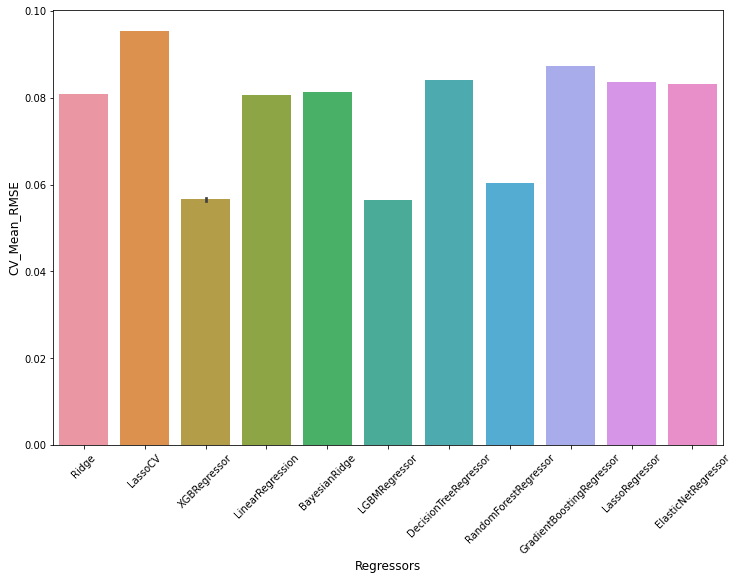

In [125]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Regressors'],final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [92]:
RS = 1
ROUNDS = 1500 # 1300,1400 all works fine
'''params = {
    'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'learning_rate': 0.01 , #small learn rate, large number of iterations
        'verbose': 0,
        'num_leaves': 2 ** 5,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction': 0.7,
        'feature_fraction_seed': RS,
        'max_bin': 100,
        'max_depth': 7,
        'num_rounds': ROUNDS,
    }'''
params = {'num_leaves': 32,
         'learning_rate': 0.01,
         'max_depth': 7,
         'boosting': 'gbdt',
         'bagging_fraction': 0.9186160036326028,
         'feature_fraction': 0.7,
         'objective': 'regression',
         'metric': 'rmse',
         'verbose': 0,
         'num_rounds': 1500,
         'max_bin': 100,
         'bagging_freq': 1,
         'bagging_seed': RS,
         'feature_fraction_seed': RS}

In [93]:
train_lgb=lgb.Dataset(X_train_final,y_train_box_cox)
model=lgb.train(params,train_lgb,num_boost_round=ROUNDS)
predict=model.predict(X_test_final)
predict=inv_boxcox(predict, y_train_lambda)

/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [94]:
xgb_params = {'learning_rate': 0.05,
             'colsample_bytree': 0.8,
             'subsample': 0.7,
             'max_depth': 9,
             'random_state': 42,
             'objective': 'reg:linear',
             'metric': 'rmse',
             'silent': 1}

'''{
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1,
    }'''

x_train=X_train_final.copy()
x_test=X_test_final.copy()


num_boost_rounds=345
dtrain = xgb.DMatrix(x_train, y_train_box_cox)
dtest = xgb.DMatrix(x_test)
model = xgb.train(dict(xgb_params, max_depth=5,silent=1), dtrain,num_boost_round= num_boost_rounds)
y_predict=inv_boxcox(model.predict(dtest), y_train_lambda)

[19:30:31] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:31] WARNING: ../src/learner.cc:541: 
Parameters: { metric, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [95]:
predict

array([5359885.50635549, 8453201.40815137, 5287832.12726152, ...,
       3772442.74826955, 5481902.83758628, 8120825.36672345])

In [96]:
X_test['price_doc'] = predict

In [97]:
X_test = X_test.drop(X_test.iloc[:,0:-1], axis=1)

In [98]:
X_test

,price_doc
id,
30474,5.359886e+06
30475,8.453201e+06
30476,5.287832e+06
30477,6.241322e+06
30478,5.175730e+06
...,...
38131,8.537488e+06
38132,5.187323e+06
38133,3.772443e+06


In [99]:
X_test.to_csv('Submission_LGBM_bharat.csv')

In [100]:
y_predict

array([5600179.5, 8593683. , 5004388.5, ..., 3932382.8, 5656381. ,
       8274710.5], dtype=float32)

In [101]:
X_test['price_doc'] = y_predict

In [102]:
X_test

,price_doc
id,
30474,5600179.50
30475,8593683.00
30476,5004388.50
30477,6127336.00
30478,5145585.00
...,...
38131,8654422.00
38132,4848127.00
38133,3932382.75


In [103]:
X_test.to_csv('Submission_XGB_bharat.csv')

In [104]:
y_pred = (predict+y_predict)/2

In [105]:
X_test['price_doc'] = y_pred

In [106]:
X_test

,price_doc
id,
30474,5.480033e+06
30475,8.523442e+06
30476,5.146110e+06
30477,6.184329e+06
30478,5.160658e+06
...,...
38131,8.595955e+06
38132,5.017725e+06
38133,3.852413e+06


In [107]:
X_test.to_csv('Submission_Combined_Aggregation.csv')

## 7) Model Ensembling

In [108]:
train_lgb=lgb.Dataset(X_train_final,y_train_box_cox)
lgbm_model=lgb.train(params,train_lgb,num_boost_round=ROUNDS)
predict=lgbm_model.predict(X_train_final)

/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [109]:
num_boost_rounds=345
dtrain = xgb.DMatrix(x_train, y_train_box_cox)
dtest = xgb.DMatrix(X_train_final)
xgb_model = xgb.train(dict(xgb_params, max_depth=5,silent=1), dtrain,num_boost_round= num_boost_rounds)
y_predict= xgb_model.predict(dtest)

[19:31:08] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: ../src/learner.cc:541: 
Parameters: { metric, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [110]:
ensemble_train = pd.DataFrame({'LGBM':predict,
                               'XGB':y_predict})

In [111]:
ensemble_train

,LGBM,XGB
0,7.917550,7.914396
1,7.913905,7.904088
2,7.901639,7.905679
3,8.036803,8.029385
4,8.065531,8.078782
...,...,...
28397,7.949945,7.950965
28398,8.155827,8.120433
28399,7.906147,7.910120
28400,8.061960,8.053844


In [224]:
ensemble_model = Ridge(alpha = 2).fit(ensemble_train, y_train_box_cox)

In [225]:
predict=lgbm_model.predict(X_test_final)

In [226]:
dtest = xgb.DMatrix(X_test_final)
y_predict=xgb_model.predict(dtest)

In [227]:
ensemble_test = pd.DataFrame({'LGBM':predict,
                               'XGB':y_predict})

In [228]:
ensemble_test

,LGBM,XGB
0,7.892605,7.901949
1,7.987716,7.991077
2,7.889713,7.877901
3,7.924870,7.920990
4,7.885126,7.883874
...,...,...
7657,7.989740,7.992511
7658,7.885606,7.871069
7659,7.816280,7.825443
7660,7.897406,7.904071


In [229]:
y_pred = ensemble_model.predict(ensemble_test)

In [230]:
y_pred

array([7.89424304, 7.99253103, 7.88319513, ..., 7.81348669, 7.89830675,
       7.98404239])

In [231]:
y_pred = inv_boxcox(y_pred, y_train_lambda)

In [232]:
X_test['price_doc'] = y_pred

In [233]:
X_test = X_test.drop(X_test.iloc[:,0:-1], axis=1)

In [234]:
X_test

,price_doc
id,
30474,5.401177e+06
30475,8.655270e+06
30476,5.129315e+06
30477,6.196621e+06
30478,5.108785e+06
...,...
38131,8.737183e+06
38132,5.002617e+06
38133,3.725125e+06


In [235]:
X_test.to_csv('Submission_Improved_Combined_Ridge2_Optune_GridSearch.csv')

In [223]:
y_train_lambda = -0.09964593857754662

## 7) Outlier Removal

In [ ]:
'''y_pred = xgb.predict(X_train_final)'''
'''y_pred'''
'''y_pred = inv_boxcox(y_pred, y_train_lambda)'''
'''X_train_ID = X_train_final.reset_index()'''
'''X_train_ID'''
'''error = y_pred - (inv_boxcox(y_train_box_cox, y_train_lambda))'''

'''rmse = np.sqrt(sum(((inv_boxcox(y_train_box_cox, y_train_lambda))-y_pred)**2)/len((inv_boxcox(y_train_box_cox, y_train_lambda))))
ei = error/rmse
plt.scatter(X_train_ID.id, ei)'''

'''X_train_final['ei'] = ei
X_train_final['outlier'] = X_train_final['ei'].apply(lambda x : True if (x<-5 or x>5) else False)'''

'''index = X_train_final.index[X_train_final['outlier']==True]
index'''

'''y_train_box_cox = np.delete(y_train_box_cox, index)'''

'''X_train_final.drop(X_train_final.index[X_train_final['outlier']==True], inplace=True)'''

'''X_train_final.drop(['outlier', 'ei'], axis=1, inplace=True)'''

'''X_train_final'''

## 8) Final Output